<a href="https://www.kaggle.com/code/jaksanders/breast-cancer-survival?scriptVersionId=157143536" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Comparing Algorithms for Breast Cancer Survival Prediction

Which features are the most predictive of overall survival?  Genetics, treatment, other clinical factors?

How accurate a model can we build to predict survival?

# Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import seaborn as sns
!pip install scikit-survival
from sksurv.meta import EnsembleSelection
from sksurv.svm import FastSurvivalSVM, FastKernelSurvivalSVM
from sksurv.tree import SurvivalTree
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, VarianceThreshold, RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn import set_config
import xgboost as xgb
import shap
import pickle
import time
from copy import deepcopy
from functools import cache
import warnings
warnings.filterwarnings("ignore")
randomState = 42 # tip of the cap to Douglas Adams
set_config(transform_output="pandas")
Verbosity = 0

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


# Load Data

TCGA breast invasive carcinoma (BRCA) gene expression by RNAseq (polyA+ IlluminaHiSeq percentile)


Goldman, M.J., Craft, B., Hastie, M. et al. Visualizing and interpreting cancer genomics data via the Xena platform. Nat Biotechnol (2020). https://doi.org/10.1038/s41587-020-0546-8

In [2]:
# load data
# load gene expression data
geneExpressionData = pd.read_csv('/kaggle/input/breast-cancer/TCGA.BRCA.sampleMap_HiSeqV2_percentile/HiSeqV2_percentile', sep='\t')
geneExpressionData

sample  TCGA-AR-A5QQ-01  TCGA-D8-A1JA-01  TCGA-BH-A0BQ-01  \
0      ARHGEF10L          67.6890          43.2552          64.3948   
1          HIF3A           7.3010          18.8283          11.5102   
2          RNF17           0.0000           3.7593           1.3625   
3          RNF10          91.0699          93.9684          95.1058   
4          RNF11          89.1384          98.9692          92.1185   
...          ...              ...              ...              ...   
20525       PTRF          98.9073          84.0504          98.1215   
20526      BCL6B          39.3524          41.4333          48.9083   
20527      GSTK1          91.4665          64.3905          91.5427   
20528       SELP          43.8659           0.0000          49.5639   
20529       SELS          85.0842          76.9937          74.4570   

       TCGA-BH-A0BT-01  TCGA-A8-A06X-01  TCGA-A8-A096-01  TCGA-BH-A0C7-01  \
0              60.4877          69.7906          71.5039          76.8329   
1               6.7588           1.5644           1.1943          18.0518   
2               0.0000           0.0000           5.9261           0.0000   
3              98.4396          95.2534          94.4729          92.0332   
4              89.0831          90.5039          86.9705          86.0673   
...                ...              ...              ...              ...   
20525          96.5183          91.1427          97.6769          94.7756   
20526          43.9916          42.9497          55.1052          45.1142   
20527          90.9078          84.9885          82.7917          85.8714   
20528          37.7132          36.9314          27.8604          33.2326   
20529          65.8680          89.7587          73.2427          71.1411   

       TCGA-AC-A5XU-01  TCGA-PE-A5DE-01  ...  TCGA-A7-A13E-11  \
0              61.6060          74.6299  ...          69.7743   
1               1.5093          13.3623  ...          47.7255   
2               0.0000           0.0000  ...           0.0000   
3              93.0050          96.6537  ...          94.9079   
4              82.2452          91.1042  ...          94.6150   
...                ...              ...  ...              ...   
20525          97.9389          96.4251  ...          99.5252   
20526          58.7902          49.1513  ...          71.9436   
20527          92.4218          93.0588  ...          93.4067   
20528          18.4323          56.6011  ...          75.1564   
20529          79.8839          76.9103  ...          70.2690   

       TCGA-C8-A8HP-01  TCGA-E9-A5FL-01  TCGA-AC-A2FB-11  TCGA-E2-A15F-01  \
0              78.4623          74.3606          74.1559          75.9240   
1               9.5156          15.6451          47.7195           3.7018   
2               0.0000          14.9662           0.0000           0.0000   
3              96.2191          96.3634          94.6336          95.6244   
4              91.6460          82.0761          93.2331          86.7963   
...                ...              ...              ...              ...   
20525          96.1543          97.7521          99.6153          91.2231   
20526          40.4618          46.5099          62.4350          43.0143   
20527          92.2550          88.5831          92.1538          86.0144   
20528          37.2871          19.8873          71.1392          48.2145   
20529          78.3016          77.5577          73.3422          78.7672   

       TCGA-A2-A3XT-01  TCGA-B6-A0X7-01  TCGA-BH-A1EV-11  TCGA-3C-AALJ-01  \
0              92.7702          83.8835          66.2846          87.8746   
1               8.3572          17.8496          37.6901           1.9467   
2               7.3560           0.9961           0.0000           0.0000   
3              93.2273          95.1562          92.9888          96.2317   
4              79.4324          86.3168          94.8982          86.2539   
...                ...              ...              ...        

Curated survival data from the Pan-cancer Atlas paper titled "An Integrated TCGA Pan-Cancer Clinical Data Resource (TCGA-CDR) to drive high quality survival outcome analytics". The paper highlights four types of carefully curated survival endpoints, and recommends the use of the endpoints of OS, PFI, DFI, and DSS for each TCGA cancer type.


OS: overall survial

PFI: progression-free interval

DSS: disease-specific survival

DFI: disease-free interval

In [3]:
# load survival data
survivalData = pd.read_csv('/kaggle/input/breast-cancer/tcga-xena-hub.s3.us-east-1.amazonaws.com_download_survival2FBRCA_survival.txt', sep='\t')
survivalData

sample      _PATIENT  OS  OS.time  DSS  DSS.time  DFI  \
0     TCGA-3C-AAAU-01  TCGA-3C-AAAU   0   4047.0  0.0    4047.0  1.0   
1     TCGA-3C-AALI-01  TCGA-3C-AALI   0   4005.0  0.0    4005.0  0.0   
2     TCGA-3C-AALJ-01  TCGA-3C-AALJ   0   1474.0  0.0    1474.0  0.0   
3     TCGA-3C-AALK-01  TCGA-3C-AALK   0   1448.0  0.0    1448.0  NaN   
4     TCGA-4H-AAAK-01  TCGA-4H-AAAK   0    348.0  0.0     348.0  0.0   
...               ...           ...  ..      ...  ...       ...  ...   
1231  TCGA-WT-AB44-01  TCGA-WT-AB44   0    883.0  0.0     883.0  0.0   
1232  TCGA-XX-A899-01  TCGA-XX-A899   0    467.0  0.0     467.0  0.0   
1233  TCGA-XX-A89A-01  TCGA-XX-A89A   0    488.0  0.0     488.0  0.0   
1234  TCGA-Z7-A8R5-01  TCGA-Z7-A8R5   0   3287.0  0.0    3287.0  NaN   
1235  TCGA-Z7-A8R6-01  TCGA-Z7-A8R6   0   3256.0  0.0    3256.0  0.0   

      DFI.time  PFI  PFI.time Redaction  
0       1808.0    1    1808.0       NaN  
1       4005.0    0    4005.0       NaN  
2       1474.0    0    1474.0       NaN  
3          NaN    0    1448.0       NaN  
4        348.0    0     348.0       NaN  
...        ...  ...       ...       ...  
1231     883.0    0     883.0       NaN  
1232     467.0    0     467.0       NaN  
1233     488.0    0     488.0       NaN  
1234       NaN    1     181.0       NaN  
1235    3256.0    0    3256.0       NaN  

[1236 rows x 11 columns]

In [4]:
# load clinical data
clinicalData = pd.read_csv('/kaggle/input/breast-cancer/TCGA.BRCA.sampleMap_BRCA_clinicalMatrix', sep='\t')
clinicalData

sampleID AJCC_Stage_nature2012  \
0     TCGA-3C-AAAU-01                   NaN   
1     TCGA-3C-AALI-01                   NaN   
2     TCGA-3C-AALJ-01                   NaN   
3     TCGA-3C-AALK-01                   NaN   
4     TCGA-4H-AAAK-01                   NaN   
...               ...                   ...   
1242  TCGA-XX-A899-01                   NaN   
1243  TCGA-XX-A899-11                   NaN   
1244  TCGA-XX-A89A-01                   NaN   
1245  TCGA-Z7-A8R5-01                   NaN   
1246  TCGA-Z7-A8R6-01                   NaN   

      Age_at_Initial_Pathologic_Diagnosis_nature2012  CN_Clusters_nature2012  \
0                                                NaN                     NaN   
1                                                NaN                     NaN   
2                                                NaN                     NaN   
3                                                NaN                     NaN   
4                                                NaN                     NaN   
...                                              ...                     ...   
1242                                             NaN                     NaN   
1243                                             NaN                     NaN   
1244                                             NaN                     NaN   
1245                                             NaN                     NaN   
1246                                             NaN                     NaN   

     Converted_Stage_nature2012  Days_to_Date_of_Last_Contact_nature2012  \
0                           NaN                                      NaN   
1                           NaN                                      NaN   
2                           NaN                                      NaN   
3                           NaN                                      NaN   
4                           NaN                                      NaN   
...                         ...                                      ...   
1242                        NaN                                      NaN   
1243                        NaN                                      NaN   
1244                        NaN                                      NaN   
1245                        NaN                                      NaN   
1246                        NaN                                      NaN   

      Days_to_date_of_Death_nature2012 ER_Status_nature2012 Gender_nature2012  \
0                                  NaN                  NaN               NaN   
1                                  NaN                  NaN               NaN   
2                                  NaN                  NaN               NaN   
3                                  NaN                  NaN               NaN   
4                                  NaN                  NaN               NaN   
...                                ...                  ...               ...   
1242                               NaN                  NaN               NaN   
1243                               NaN                  NaN               NaN   
1244                               NaN                  NaN               NaN   
1245                               NaN                  NaN               NaN   
1246                               NaN                  NaN               NaN   

     HER2_Final_Status_nature2012  ...  \
0                             NaN  ...   
1                             NaN  ...   
2                             NaN  ...   
3                             NaN  ...   
4                             NaN  ...   
...                           ...  ...   
1242                          NaN  ...   
1243                          NaN  ...   
1244                          NaN  ...   
1245                          NaN  ...   
1246                          NaN  ...   

      _GENOMIC_ID_TCGA_BRCA_mutation_wustl_gene  \
0                                           N

In [5]:
# profile the clinical dataset
# takes about 4.5 minutes
# start_time = time.time()
# profile = ProfileReport(clinicalData)
# profile.to_file('clinicalData profile_report.html')
# print('%s seconds' % (time.time() - start_time))
# # profile

In [6]:
geneExpressionData

sample  TCGA-AR-A5QQ-01  TCGA-D8-A1JA-01  TCGA-BH-A0BQ-01  \
0      ARHGEF10L          67.6890          43.2552          64.3948   
1          HIF3A           7.3010          18.8283          11.5102   
2          RNF17           0.0000           3.7593           1.3625   
3          RNF10          91.0699          93.9684          95.1058   
4          RNF11          89.1384          98.9692          92.1185   
...          ...              ...              ...              ...   
20525       PTRF          98.9073          84.0504          98.1215   
20526      BCL6B          39.3524          41.4333          48.9083   
20527      GSTK1          91.4665          64.3905          91.5427   
20528       SELP          43.8659           0.0000          49.5639   
20529       SELS          85.0842          76.9937          74.4570   

       TCGA-BH-A0BT-01  TCGA-A8-A06X-01  TCGA-A8-A096-01  TCGA-BH-A0C7-01  \
0              60.4877          69.7906          71.5039          76.8329   
1               6.7588           1.5644           1.1943          18.0518   
2               0.0000           0.0000           5.9261           0.0000   
3              98.4396          95.2534          94.4729          92.0332   
4              89.0831          90.5039          86.9705          86.0673   
...                ...              ...              ...              ...   
20525          96.5183          91.1427          97.6769          94.7756   
20526          43.9916          42.9497          55.1052          45.1142   
20527          90.9078          84.9885          82.7917          85.8714   
20528          37.7132          36.9314          27.8604          33.2326   
20529          65.8680          89.7587          73.2427          71.1411   

       TCGA-AC-A5XU-01  TCGA-PE-A5DE-01  ...  TCGA-A7-A13E-11  \
0              61.6060          74.6299  ...          69.7743   
1               1.5093          13.3623  ...          47.7255   
2               0.0000           0.0000  ...           0.0000   
3              93.0050          96.6537  ...          94.9079   
4              82.2452          91.1042  ...          94.6150   
...                ...              ...  ...              ...   
20525          97.9389          96.4251  ...          99.5252   
20526          58.7902          49.1513  ...          71.9436   
20527          92.4218          93.0588  ...          93.4067   
20528          18.4323          56.6011  ...          75.1564   
20529          79.8839          76.9103  ...          70.2690   

       TCGA-C8-A8HP-01  TCGA-E9-A5FL-01  TCGA-AC-A2FB-11  TCGA-E2-A15F-01  \
0              78.4623          74.3606          74.1559          75.9240   
1               9.5156          15.6451          47.7195           3.7018   
2               0.0000          14.9662           0.0000           0.0000   
3              96.2191          96.3634          94.6336          95.6244   
4              91.6460          82.0761          93.2331          86.7963   
...                ...              ...              ...              ...   
20525          96.1543          97.7521          99.6153          91.2231   
20526          40.4618          46.5099          62.4350          43.0143   
20527          92.2550          88.5831          92.1538          86.0144   
20528          37.2871          19.8873          71.1392          48.2145   
20529          78.3016          77.5577          73.3422          78.7672   

       TCGA-A2-A3XT-01  TCGA-B6-A0X7-01  TCGA-BH-A1EV-11  TCGA-3C-AALJ-01  \
0              92.7702          83.8835          66.2846          87.8746   
1               8.3572          17.8496          37.6901           1.9467   
2               7.3560           0.9961           0.0000           0.0000   
3              93.2273          95.1562          92.9888          96.2317   
4              79.4324          86.3168          94.8982          86.2539   
...                ...              ...              ...        

In [7]:
geneExpressionData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20530 entries, 0 to 20529
Columns: 1219 entries, sample to TCGA-B6-A0X1-01
dtypes: float64(1218), object(1)
memory usage: 190.9+ MB


In [8]:
# start_time = time.time()
# profile = ProfileReport(survivalData)
# profile.to_file('survivalData profile_report.html')
# print('%s seconds' % (time.time() - start_time))
# # profile

# Data Pre-processing

In [9]:
# join datasets together
# print(geneExpressionData)
gene_samples = geneExpressionData['sample'].unique()
gene_samples.sort()
print('gene_samples\n', gene_samples)
print(gene_samples.shape)
pd.DataFrame(gene_samples).to_csv("gene_samples.csv")

survival_samples = survivalData['sample'].unique()
print('survival_samples\n', survival_samples)

clinical_samples = clinicalData['sampleID'].unique()
print('clinical_samples\n', clinical_samples)


gene_samples
 ['?|100130426' '?|100133144' '?|100134869' ... 'ZZZ3' 'psiTPTE22' 'tAKR']
(20530,)
survival_samples
 ['TCGA-3C-AAAU-01' 'TCGA-3C-AALI-01' 'TCGA-3C-AALJ-01' ...
 'TCGA-XX-A89A-01' 'TCGA-Z7-A8R5-01' 'TCGA-Z7-A8R6-01']
clinical_samples
 ['TCGA-3C-AAAU-01' 'TCGA-3C-AALI-01' 'TCGA-3C-AALJ-01' ...
 'TCGA-XX-A89A-01' 'TCGA-Z7-A8R5-01' 'TCGA-Z7-A8R6-01']


Observation: in the gene expression dataset, the sample IDs are in the column names, and gene IDs are in the 'sample' column, so...

We'll need to transpose the gene dataset in order to combine it with survival and clinical data

In [10]:
# transpose the gene dataset so it matches up structurally with the clinical and survival data
geneTranspose = geneExpressionData.set_index('sample')
geneTranspose = geneTranspose.transpose()
geneTranspose.reset_index(names='sampleID', inplace=True)
print(geneTranspose.info())
geneTranspose


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Columns: 20531 entries, sampleID to SELS
dtypes: float64(20530), object(1)
memory usage: 190.8+ MB
None


sample         sampleID  ARHGEF10L    HIF3A   RNF17    RNF10    RNF11  \
0       TCGA-AR-A5QQ-01    67.6890   7.3010  0.0000  91.0699  89.1384   
1       TCGA-D8-A1JA-01    43.2552  18.8283  3.7593  93.9684  98.9692   
2       TCGA-BH-A0BQ-01    64.3948  11.5102  1.3625  95.1058  92.1185   
3       TCGA-BH-A0BT-01    60.4877   6.7588  0.0000  98.4396  89.0831   
4       TCGA-A8-A06X-01    69.7906   1.5644  0.0000  95.2534  90.5039   
...                 ...        ...      ...     ...      ...      ...   
1213    TCGA-A2-A3XT-01    92.7702   8.3572  7.3560  93.2273  79.4324   
1214    TCGA-B6-A0X7-01    83.8835  17.8496  0.9961  95.1562  86.3168   
1215    TCGA-BH-A1EV-11    66.2846  37.6901  0.0000  92.9888  94.8982   
1216    TCGA-3C-AALJ-01    87.8746   1.9467  0.0000  96.2317  86.2539   
1217    TCGA-B6-A0X1-01    80.0284  11.8370  0.0000  96.1641  90.5849   

sample    RNF13  GTF2IP1     REM1    MTVR2  ...    TULP2    NPY5R    GNGT2  \
0       75.0670  92.6020  15.0357   0.0000  ...   1.5121   0.0000  25.1184   
1       85.6586  95.8567  13.9978   0.0000  ...   6.6900   0.0000  16.2413   
2       81.8710  97.7339  20.2297   0.0000  ...   0.0000  11.5102  18.4140   
3       81.6024  97.4619  13.5772   0.0000  ...   0.0000  14.5862  20.6344   
4       77.8376  97.4833  20.2904   8.7005  ...   6.1543   1.5644  16.8273   
...         ...      ...      ...      ...  ...      ...      ...      ...   
1213    74.6340  96.7665  20.0768  10.9821  ...  10.4521  12.7685  25.7558   
1214    82.5972  98.0790  22.8954   0.0000  ...   5.5154  24.7965  15.6611   
1215    89.5175  97.9566  23.0468   3.3921  ...   8.1191  26.3760  18.9353   
1216    68.2448  97.7798  21.0993   0.0000  ...   0.0000   1.9467  17.6774   
1217    72.2232  91.5020  26.1556   1.7291  ...   1.7291   8.0295  24.8410   

sample    GNGT1    TULP3     PTRF    BCL6B    GSTK1     SELP     SELS  
0        1.5121  62.4337  98.9073  39.3524  91.4665  43.8659  85.0842  
1       19.4433  73.2459  84.0504  41.4333  64.3905   0.0000  76.9937  
2        0.0000  62.9041  98.1215  48.9083  91.5427  49.5639  74.4570  
3        0.0000  57.1510  96.5183  43.9916  90.9078  37.7132  65.8680  
4        0.0000  64.5206  91.1427  42.9497  84.9885  36.9314  89.7587  
...         ...      ...      ...      ...      ...      ...      ...  
1213     0.0000  65.3346  90.5351  52.5380  87.8372  29.1071  86.4855  
1214     0.0000  63.9336  97.8855  60.3335  90.4633  53.6115  69.5429  
1215     1.2912  74.4474  98.5967  55.2905  87.9391  67.6879  70.3551  
1216     5.0922  64.3805  97.2502  55.1330  95.3762  25.2692  78.0917  
1217     0.0000  87.7229  68.2368  30.8348  93.3646   8.0295  66.5730  

[1218 rows x 20531 columns]

In [11]:
# calculate basic statistics for the gene dataset
geneStats = geneTranspose.describe().transpose()

In [12]:
# eliminate genes with zero records
zeroCountGenes = geneStats[geneStats['count']==0]
if Verbosity > 0:
    print('Removing genes with zero records:\n', zeroCountGenes)
geneTranspose.drop(columns=zeroCountGenes.index, inplace=True)
geneTranspose

sample         sampleID  ARHGEF10L    HIF3A   RNF17    RNF10    RNF11  \
0       TCGA-AR-A5QQ-01    67.6890   7.3010  0.0000  91.0699  89.1384   
1       TCGA-D8-A1JA-01    43.2552  18.8283  3.7593  93.9684  98.9692   
2       TCGA-BH-A0BQ-01    64.3948  11.5102  1.3625  95.1058  92.1185   
3       TCGA-BH-A0BT-01    60.4877   6.7588  0.0000  98.4396  89.0831   
4       TCGA-A8-A06X-01    69.7906   1.5644  0.0000  95.2534  90.5039   
...                 ...        ...      ...     ...      ...      ...   
1213    TCGA-A2-A3XT-01    92.7702   8.3572  7.3560  93.2273  79.4324   
1214    TCGA-B6-A0X7-01    83.8835  17.8496  0.9961  95.1562  86.3168   
1215    TCGA-BH-A1EV-11    66.2846  37.6901  0.0000  92.9888  94.8982   
1216    TCGA-3C-AALJ-01    87.8746   1.9467  0.0000  96.2317  86.2539   
1217    TCGA-B6-A0X1-01    80.0284  11.8370  0.0000  96.1641  90.5849   

sample    RNF13  GTF2IP1     REM1    MTVR2  ...    TULP2    NPY5R    GNGT2  \
0       75.0670  92.6020  15.0357   0.0000  ...   1.5121   0.0000  25.1184   
1       85.6586  95.8567  13.9978   0.0000  ...   6.6900   0.0000  16.2413   
2       81.8710  97.7339  20.2297   0.0000  ...   0.0000  11.5102  18.4140   
3       81.6024  97.4619  13.5772   0.0000  ...   0.0000  14.5862  20.6344   
4       77.8376  97.4833  20.2904   8.7005  ...   6.1543   1.5644  16.8273   
...         ...      ...      ...      ...  ...      ...      ...      ...   
1213    74.6340  96.7665  20.0768  10.9821  ...  10.4521  12.7685  25.7558   
1214    82.5972  98.0790  22.8954   0.0000  ...   5.5154  24.7965  15.6611   
1215    89.5175  97.9566  23.0468   3.3921  ...   8.1191  26.3760  18.9353   
1216    68.2448  97.7798  21.0993   0.0000  ...   0.0000   1.9467  17.6774   
1217    72.2232  91.5020  26.1556   1.7291  ...   1.7291   8.0295  24.8410   

sample    GNGT1    TULP3     PTRF    BCL6B    GSTK1     SELP     SELS  
0        1.5121  62.4337  98.9073  39.3524  91.4665  43.8659  85.0842  
1       19.4433  73.2459  84.0504  41.4333  64.3905   0.0000  76.9937  
2        0.0000  62.9041  98.1215  48.9083  91.5427  49.5639  74.4570  
3        0.0000  57.1510  96.5183  43.9916  90.9078  37.7132  65.8680  
4        0.0000  64.5206  91.1427  42.9497  84.9885  36.9314  89.7587  
...         ...      ...      ...      ...      ...      ...      ...  
1213     0.0000  65.3346  90.5351  52.5380  87.8372  29.1071  86.4855  
1214     0.0000  63.9336  97.8855  60.3335  90.4633  53.6115  69.5429  
1215     1.2912  74.4474  98.5967  55.2905  87.9391  67.6879  70.3551  
1216     5.0922  64.3805  97.2502  55.1330  95.3762  25.2692  78.0917  
1217     0.0000  87.7229  68.2368  30.8348  93.3646   8.0295  66.5730  

[1218 rows x 20502 columns]

In [13]:
# generate correlation matrix for the gene dataset, so we can remove high correlation genes
# ~23 minutes
start_time = time.time() # start the timer
corr_matrix = geneTranspose.corr().abs()
print('%s seconds' % (time.time() - start_time))
# print(corr_matrix)

1388.1199126243591 seconds


In [14]:
# save correlation matrix...expensive to calcualte
with open('corr_matrix.pkl', 'wb') as f:
    pickle.dump(corr_matrix, f)

In [15]:
# restore correlation matrix
with open('corr_matrix.pkl', 'rb') as f:
    corr_matrix = pickle.load(f)

In [16]:
if Verbosity > 0:
    corr_matrix

In [17]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
if Verbosity > 0:
    upper


In [18]:
# Find features with correlation greater than 0.85
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

In [19]:
if Verbosity > 0:
    print('dropping: ', len(to_drop), ' highly correlated genes:\n', to_drop)

In [20]:
# Drop highly correlated genes 
geneTranspose.drop(to_drop, axis=1, inplace=True)

In [21]:
# calculate basic statistics for the gene dataset
geneStats = geneTranspose.describe().transpose()

In [22]:
# eliminate genes with low variation (standard deviation)
lowStdGenes = geneStats[geneStats['std'] <= 17] # I adjuested the threshold by hand to get ~900 genes
if Verbosity > 0:
    print('dropping low variation genes:\n', lowStdGenes)
geneTranspose.drop(columns=lowStdGenes.index, inplace=True)
if Verbosity > 0:
    geneTranspose

In [23]:
geneStats = geneTranspose.describe().transpose()
if Verbosity > 0:
    geneStats.sort_values('std')

In [24]:
# create a list of gene column names 
geneColNames = list(geneTranspose.columns)
geneColNames.remove('sampleID')
if Verbosity > 0:
    geneColNames

In [25]:
# save gene column names
with open('geneColNames.pkl', 'wb') as f:
    pickle.dump(geneColNames, f)

with open('geneColNames.pkl', 'rb') as f:
    geneColNames = pickle.load(f)


In [26]:
# looks like the clinial and survival datasets have an easy join
# the join columns need to have the same name to use the merge function...
# so will copy the 'sample' column in survival data to a new 'sampleID' column
mergeSurvival = survivalData.copy()
mergeSurvival['sampleID'] = mergeSurvival['sample']
mergeSurvival.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1236 entries, 0 to 1235
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample     1236 non-null   object 
 1   _PATIENT   1236 non-null   object 
 2   OS         1236 non-null   int64  
 3   OS.time    1235 non-null   float64
 4   DSS        1206 non-null   float64
 5   DSS.time   1235 non-null   float64
 6   DFI        1055 non-null   float64
 7   DFI.time   1054 non-null   float64
 8   PFI        1236 non-null   int64  
 9   PFI.time   1235 non-null   float64
 10  Redaction  6 non-null      object 
 11  sampleID   1236 non-null   object 
dtypes: float64(6), int64(2), object(4)
memory usage: 116.0+ KB


In [27]:
# now that clinial and survival datasets both have a sampleID column, we can merge...
mergeSurvivalClinical = pd.merge(clinicalData, mergeSurvival, on='sampleID')
print(mergeSurvivalClinical.info())
mergeSurvivalClinical

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1236 entries, 0 to 1235
Columns: 205 entries, sampleID to Redaction
dtypes: float64(40), int64(3), object(162)
memory usage: 1.9+ MB
None


sampleID AJCC_Stage_nature2012  \
0     TCGA-3C-AAAU-01                   NaN   
1     TCGA-3C-AALI-01                   NaN   
2     TCGA-3C-AALJ-01                   NaN   
3     TCGA-3C-AALK-01                   NaN   
4     TCGA-4H-AAAK-01                   NaN   
...               ...                   ...   
1231  TCGA-WT-AB44-01                   NaN   
1232  TCGA-XX-A899-01                   NaN   
1233  TCGA-XX-A89A-01                   NaN   
1234  TCGA-Z7-A8R5-01                   NaN   
1235  TCGA-Z7-A8R6-01                   NaN   

      Age_at_Initial_Pathologic_Diagnosis_nature2012  CN_Clusters_nature2012  \
0                                                NaN                     NaN   
1                                                NaN                     NaN   
2                                                NaN                     NaN   
3                                                NaN                     NaN   
4                                                NaN                     NaN   
...                                              ...                     ...   
1231                                             NaN                     NaN   
1232                                             NaN                     NaN   
1233                                             NaN                     NaN   
1234                                             NaN                     NaN   
1235                                             NaN                     NaN   

     Converted_Stage_nature2012  Days_to_Date_of_Last_Contact_nature2012  \
0                           NaN                                      NaN   
1                           NaN                                      NaN   
2                           NaN                                      NaN   
3                           NaN                                      NaN   
4                           NaN                                      NaN   
...                         ...                                      ...   
1231                        NaN                                      NaN   
1232                        NaN                                      NaN   
1233                        NaN                                      NaN   
1234                        NaN                                      NaN   
1235                        NaN                                      NaN   

      Days_to_date_of_Death_nature2012 ER_Status_nature2012 Gender_nature2012  \
0                                  NaN                  NaN               NaN   
1                                  NaN                  NaN               NaN   
2                                  NaN                  NaN               NaN   
3                                  NaN                  NaN               NaN   
4                                  NaN                  NaN               NaN   
...                                ...                  ...               ...   
1231                               NaN                  NaN               NaN   
1232                               NaN                  NaN               NaN   
1233                               NaN                  NaN               NaN   
1234                               NaN                  NaN               NaN   
1235                               NaN                  NaN               NaN   

     HER2_Final_Status_nature2012  ...    _PATIENT_y  OS  OS.time  DSS  \
0                             NaN  ...  TCGA-3C-AAAU   0   4047.0  0.0   
1                             NaN  ...  TCGA-3C-AALI   0   4005.0  0.0   
2                             NaN  ...  TCGA-3C-AALJ   0   1474.0  0.0   
3                             NaN  ...  TCGA-3C-AALK   0   1448.0  0.0   
4                             NaN  ...  TCGA-4H-AAAK   0    348.0  0.0   
...                           ...  ...           ...  ..      ...  ...   
1231                          NaN  ...  TCGA-WT-AB44   0    883.0  0.0   
1232     

In [28]:
# save the merged Survival+Clinical dataset
mergeSurvivalClinical.to_csv('/kaggle/working/mergeSurvivalClinical.csv',index=False)

In [29]:
# from pandas_profiling import ProfileReport
# start_time = time.time()
# profile = ProfileReport(mergeSurvivalClinical)
# profile.to_file('mergeSurvivalClinical profile_report.html')
# print('%s seconds' % (time.time() - start_time))

In [30]:
# Merge the Survival+Clinical dataset with the gene expression dataset
mergeSurvivalClinicalGene = pd.merge(mergeSurvivalClinical, geneTranspose, on='sampleID')
if Verbosity > 0:
    print(mergeSurvivalClinicalGene.info())
    print(mergeSurvivalClinicalGene)

# Exploratory Data Analysis

<Axes: title={'center': 'Gene Expression by Sample'}, xlabel='sample'>

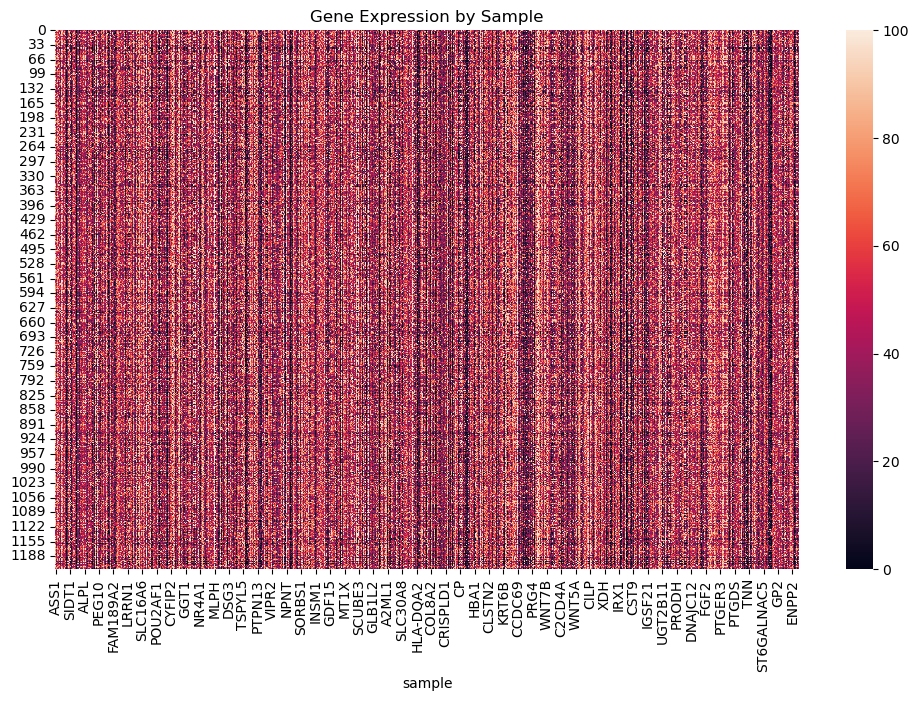

In [31]:
# heatmap of gene expression data
# Python program to generate heatmap which 
# represents panda dataframe in color-coding schemes
# along with values mentioned in each cell
    
# Defining figure size  
# for the output plot 
fig, ax = plt.subplots(figsize = (12, 7))
ax.set_title('Gene Expression by Sample')
sns.heatmap(geneTranspose.iloc[:, 1:])

In [32]:
# heatmap of gene expression data, genes sorted by average expression percentile
geneAvgExpression = geneTranspose.iloc[:, 1:].mean(axis=0)
geneAvgExpression.sort_values()

geneByAvgExp = geneTranspose.reindex(geneTranspose.iloc[:, 1:].mean().sort_values().index, axis=1)
print(geneByAvgExp)

# Defining figure size  
# for the output plot 
fig, ax = plt.subplots(figsize = (12, 7))

ax.set_title('Gene Expression by Sample')
sns.color_palette("mako", as_cmap=True)
sns.heatmap(geneByAvgExp, cmap="mako")

plt.ylabel('Sample ID')
plt.xlabel('Gene')

sample   CPLX2  CARTPT   MAGEA3     PAX7  HORMAD1  UGT2B28   CYP2A7      DCD  \
0       1.5121  0.0000  39.8944   0.0000  30.6505   0.0000   0.0000   0.0000   
1       8.6274  0.0000   0.0000  23.7108  42.5333   5.4051   0.0000  15.8948   
2       0.0000  0.0000   0.0000   1.3625   1.3625   3.6828  11.5102  32.3955   
3       6.7588  0.0000  42.9343   0.0000   1.4183   3.8682   0.0000   0.0000   
4       0.0000  0.0000   1.5644  10.3981   6.1543   0.0000   0.0000   0.0000   
...        ...     ...      ...      ...      ...      ...      ...      ...   
1213    0.0000  0.0000  48.3594   0.0000  40.4313   0.0000   0.0000   0.0000   
1214    5.5154  5.5154   0.0000   0.0000   5.5154   0.0000   0.0000   0.0000   
1215    0.0000  9.9655   0.0000  32.4270  19.7122   3.3921   4.7817   7.4762   
1216    0.0000  0.0000   0.0000   1.9467   7.0564   0.0000   0.0000   0.0000   
1217    6.5645  0.0000  35.2499   1.7291  22.4730   0.0000   0.0000   0.0000   

sample     MUC2     KRT4  ...     NPNT 

Text(0.5, 47.7222222222222, 'Gene')

# Feature Engineering

In [33]:
# make a new Unknown category for the NaNs in this feature
mergeSurvivalClinicalGene.AJCC_Stage_nature2012.replace(np.nan, 'Unknown', inplace=True)

In [34]:
# let's elimiate the 1 sample that has no data for PFI.time, DSS.time, OS.time
badSample = mergeSurvivalClinicalGene.loc[mergeSurvivalClinicalGene['PFI.time'].isna()]

badSample
print(badSample.index.tolist())

mergeSurvivalClinicalGene.drop(index=badSample.index.tolist(), inplace=True)


[1176]


In [35]:
# there are 2 records with year_of_initial_pathologic_diagnosis missing
# this is a high importance feature for the XGBoost model, so want to make it available for those models that cannot handle missing values
# so let's replace the two missing values with the mean
mean = mergeSurvivalClinicalGene.year_of_initial_pathologic_diagnosis.mean()
mergeSurvivalClinicalGene.year_of_initial_pathologic_diagnosis.fillna(value=mean, inplace=True)

In [36]:
# drop columns suspected of data leakage
mergeSurvivalClinicalGene.drop(columns=['days_to_death','Days_to_date_of_Death_nature2012'], inplace=True)
mergeSurvivalClinicalGene.drop(columns=['days_to_last_followup','days_to_last_known_alive'], inplace=True)
mergeSurvivalClinicalGene.drop(columns=['DSS', 'DFI', 'PFI'], inplace=True)
# mergeSurvivalClinicalGene.drop(columns=['AJCC_Stage_nature2012'], inplace=True) # had to drop this late in the game



In [37]:
# create list of columns that contain NaN values
NaNCols = pd.DataFrame(mergeSurvivalClinicalGene.isna().sum().sort_values(ascending=False)[lambda x : x > 0])
print(NaNCols.index)

Index(['mtsttc_brst_crcnm_hr2_rbb_ps_fndng_flrscnc_n_st_hybrdztn_clcltn',
       'metastatic_breast_carcinoma_pos_finding_hr2_rbb2_thr_msr_scl_txt',
       'hr2_n_nd_cntrmr_17_cpy_nmbr_mtsttc_brst_crcnm_nlyss_npt_ttl_nmbr',
       'days_to_additional_surgery_locoregional_procedure',
       'metastatic_breast_carcinoma_her2_erbb_method_calculatin_mthd_txt',
       'her2_neu_metastatic_breast_carcinoma_copy_analysis_inpt_ttl_nmbr',
       'mtsttc_brst_crcnm_flrscnc_n_st_hybrdztn_dgnstc_prc_cntrmr_17_sgn',
       'metastatic_breast_carcinoma_estrogen_receptor_detection_mthd_txt',
       'metastatic_breast_carcinoma_progesterone_receptor_dtctn_mthd_txt',
       'pos_finding_metastatic_brst_crcnm_strgn_rcptr_thr_msrmnt_scl_txt',
       ...
       'breast_carcinoma_surgical_procedure_name',
       'breast_carcinoma_progesterone_receptor_status',
       'breast_carcinoma_estrogen_receptor_status',
       'person_neoplasm_cancer_status', 'days_to_birth', 'pathologic_stage',
       'tissue_pros

In [38]:
# break out the target
# print(mergeSurvivalClinicalGene.describe())
y = mergeSurvivalClinicalGene[['OS']]
# y['OSBool'] = y.OS.astype(bool) # this is the format scikit-survival needs
mergeSurvivalClinicalGene.drop(columns=['OS'], inplace=True)
# mergeSurvivalClinicalGene.describe()


In [39]:
if Verbosity > 0:
    mergeSurvivalClinicalGene

In [40]:
if Verbosity > 0:
    print('y:\n', y.describe())
    print('y.OS bincount: ', np.bincount(y.OS))
    print('y:', y)

In [41]:
# save datasets
mergeSurvivalClinicalGene.to_csv('/kaggle/working/mergeSurvivalClinicalGene.csv',index=False)
y.to_csv('/kaggle/working/y.csv',index=False)


In [42]:
# restore datasets
mergeSurvivalClinicalGene = pd.read_csv('/kaggle/working/mergeSurvivalClinicalGene.csv')
y = pd.read_csv('/kaggle/working/y.csv')
with open('geneColNames.pkl', 'rb') as f:
    geneColNames = pickle.load(f)


# Split dataset in to Train and Test sets

In [43]:
X_train, X_test, y_train, y_test = train_test_split(mergeSurvivalClinicalGene, y, test_size=0.2, random_state=randomState, stratify=y)

if Verbosity > 0:
    print('X_train', X_train.shape), print('y_train', y_train.shape)
    # print(np.bincount(y_train))
    print('X_test', X_test.shape), print('y_test', y_test.shape)
    # print(np.bincount(y_test))

In [44]:
# now that we've split and stratified, supplement y with other elements of target
y['OS.time'] = mergeSurvivalClinicalGene['OS.time']
y_train['OS.time'] = X_train['OS.time']
y_test['OS.time'] = X_test['OS.time']
mergeSurvivalClinicalGene.drop(columns='OS.time', inplace=True)
X_train.drop(columns='OS.time', inplace=True)
X_test.drop(columns='OS.time', inplace=True)
# yOS_train = [[y_train, X_train['OS.time']]
# yOS_train = [[y_test, X_test['OS.time']]


In [45]:
# create boolean target that scikit-survival needs
y['OSBool'] = y.OS.astype(bool)
y_train['OSBool'] = y_train.OS.astype(bool)
y_test['OSBool'] = y_test.OS.astype(bool)

In [46]:
# convert OS.time from days to months
# this makes charts easier to interpret
y['OS.time.months'] = y['OS.time'] / 30.417

if Verbosity > 0:
    y['OS.time.months']

In [47]:
if Verbosity > 0:
    y

In [48]:
# Save X_train, y_train, X_test, y_test, y
X_train.to_csv('/kaggle/working/X_train.csv',index=False)
y_train.to_csv('/kaggle/working/y_train.csv',index=False)
X_test.to_csv('/kaggle/working/X_test.csv',index=False)
y_test.to_csv('/kaggle/working/y_test.csv',index=False)
y.to_csv('/kaggle/working/y.csv',index=False)

In [49]:
# restore X_train, y_train, X_test, y_test
X_train = pd.read_csv('/kaggle/working/X_train.csv')
y_train = pd.read_csv('/kaggle/working/y_train.csv')
X_test = pd.read_csv('/kaggle/working/X_test.csv')
y_test = pd.read_csv('/kaggle/working/y_test.csv')
y = pd.read_csv('/kaggle/working/y.csv')

In [50]:
if Verbosity > 0:
    print('\nX_train:\n', X_train.shape)
    print('\ny_train:\n', y_train.shape)
    print('\nX_test:\n', X_test.shape)
    print('\ny_test:\n', y_test.shape)
    print('\nmergeSurvivalClinicalGene:\n', mergeSurvivalClinicalGene.shape)
    print('\ny:\n', y.shape)

In [51]:
if Verbosity > 0:
    X_train

In [52]:
if Verbosity > 0:
    X_train.index

In [53]:
# Create Kaplan-Meier Survival Function for the entire dataset
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

surv_time, survival_prob, conf_int = kaplan_meier_estimator(
    y.OSBool, y['OS.time.months'], conf_type="log-log"
    # data_y["Status"], data_y["Survival_in_days"], conf_type="log-log"
)
plt.step(surv_time, survival_prob, where="post")
plt.fill_between(surv_time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.title('Kaplan-Meier Survival Function')
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (months)")
plt.savefig("Kaplan-Meier Survival Function.png")



In [54]:
item_list = mergeSurvivalClinicalGene["breast_carcinoma_surgical_procedure_name"].unique()
unwanted = {'[Discrepancy]', np.nan}
item_list = [e for e in item_list if e not in unwanted]
print(item_list)


['Modified Radical Mastectomy', 'Lumpectomy', 'Simple Mastectomy', 'Other']


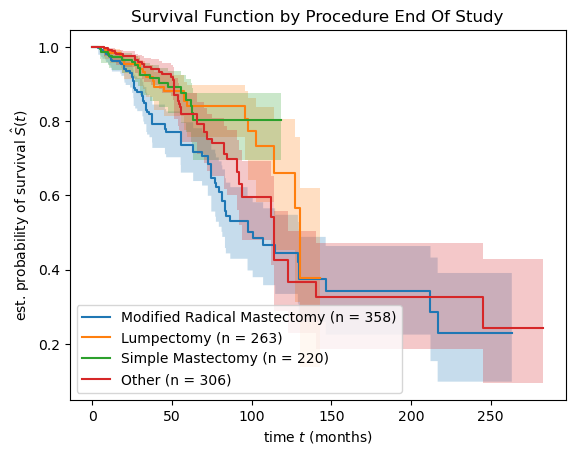

In [55]:
# Survival Function by Procedure Year 23: End Of Study
for value in item_list:
    # print(value)
    mask = mergeSurvivalClinicalGene["breast_carcinoma_surgical_procedure_name"] == value
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        y.OSBool[mask], y['OS.time.months'][mask], conf_type="log-log"
    )
    plt.step(time_cell, survival_prob_cell, where="post", label=f"{value} (n = {mask.sum()})")
    plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")

# plt.ylim(0, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (months)")
plt.legend(loc="best")
plt.title('Survival Function by Procedure End Of Study')
plt.savefig("Survival Function by Procedure End Of Study.png")

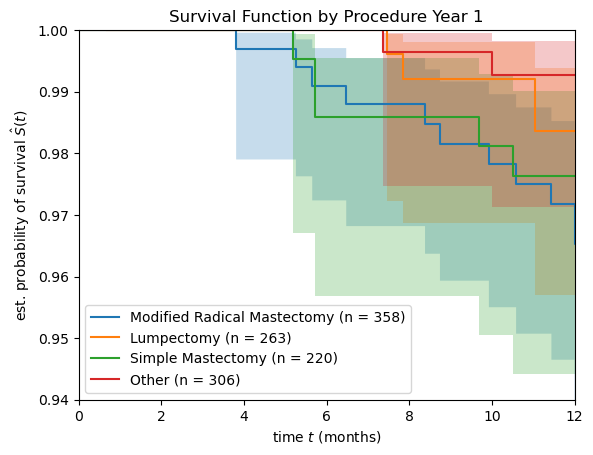

In [56]:
# Survival Function by Procedure Year 1
for value in item_list:
    # print(value)
    mask = mergeSurvivalClinicalGene["breast_carcinoma_surgical_procedure_name"] == value
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        y.OSBool[mask], y['OS.time.months'][mask], conf_type="log-log"
    )
    plt.step(time_cell, survival_prob_cell, where="post", label=f"{value} (n = {mask.sum()})")
    plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.xlim(0, 12)
plt.ylim(0.94, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (months)")
plt.legend(loc="best")
plt.title('Survival Function by Procedure Year 1')
plt.savefig("Survival Function by Procedure Year 1.png")

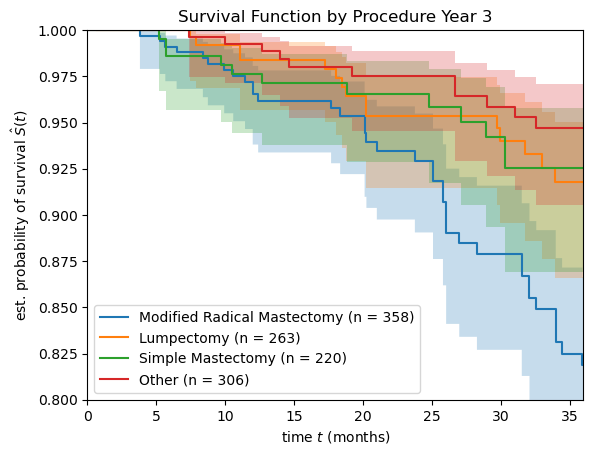

In [57]:
# Survival Function by Procedure Year 3
for value in item_list:
    # print(value)
    mask = mergeSurvivalClinicalGene["breast_carcinoma_surgical_procedure_name"] == value
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        y.OSBool[mask], y['OS.time.months'][mask], conf_type="log-log"
    )
    plt.step(time_cell, survival_prob_cell, where="post", label=f"{value} (n = {mask.sum()})")
    plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.xlim(0, 36)
plt.ylim(0.8, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (months)")
plt.legend(loc="best")
plt.title('Survival Function by Procedure Year 3')
plt.savefig("Survival Function by Procedure Year 3.png")

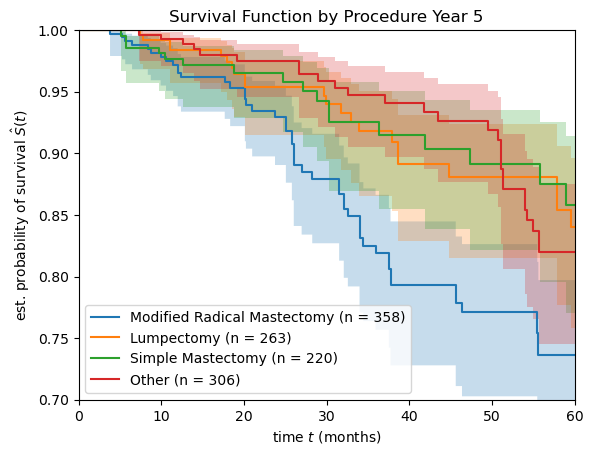

In [58]:
# Survival Function by Procedure Year 5
for value in item_list:
    # print(value)
    mask = mergeSurvivalClinicalGene["breast_carcinoma_surgical_procedure_name"] == value
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        y.OSBool[mask], y['OS.time.months'][mask], conf_type="log-log"
    )
    plt.step(time_cell, survival_prob_cell, where="post", label=f"{value} (n = {mask.sum()})")
    plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.xlim(0, 60)
plt.ylim(0.7, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (months)")
plt.legend(loc="best")
plt.title('Survival Function by Procedure Year 5')
plt.savefig("Survival Function by Procedure Year 5.png")

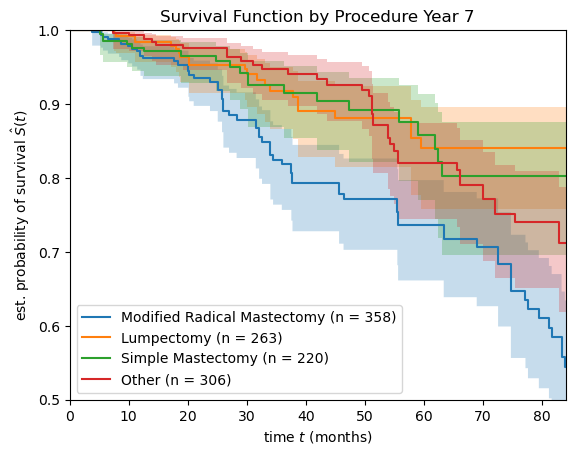

In [59]:
# Plot Survival Function by Procedure Year 7
for value in item_list:
    # print(value)
    mask = mergeSurvivalClinicalGene["breast_carcinoma_surgical_procedure_name"] == value
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        y.OSBool[mask], y['OS.time.months'][mask], conf_type="log-log"
    )
    plt.step(time_cell, survival_prob_cell, where="post", label=f"{value} (n = {mask.sum()})")
    plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.xlim(0, 84)
plt.ylim(0.5, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (months)")
plt.legend(loc="best")
plt.title('Survival Function by Procedure Year 7')
plt.savefig("Survival Function by Procedure Year 7.png")

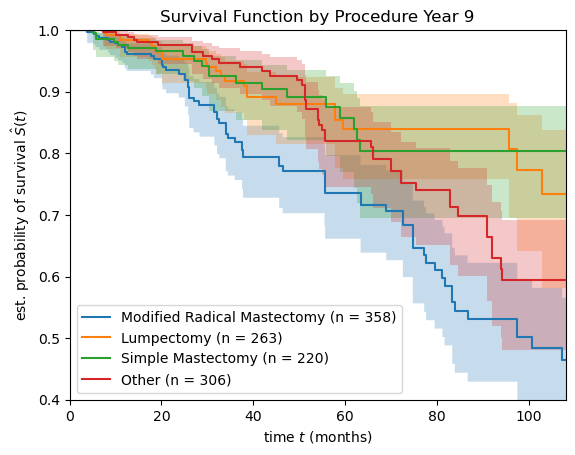

In [60]:
# Survival Function by Procedure Year 9
for value in item_list:
    # print(value)
    mask = mergeSurvivalClinicalGene["breast_carcinoma_surgical_procedure_name"] == value
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        y.OSBool[mask], y['OS.time.months'][mask], conf_type="log-log"
    )
    plt.step(time_cell, survival_prob_cell, where="post", label=f"{value} (n = {mask.sum()})")
    plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.xlim(0, 9*12)
plt.ylim(0.4, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (months)")
plt.legend(loc="best")
plt.title('Survival Function by Procedure Year 9')
plt.savefig("Survival Function by Procedure Year 9.png")

In [61]:
# this is too big to attempt
# profile = ProfileReport(mergeSurvivalClinicalGene, correlations={"auto": {"calculate": False}})
# profile.to_file('mergeSurvivalClinicalGene profile_report.html')
# profile

In [62]:
# function to format target for Scikit-Survival
# 
def format_target_for_Scikit_Survival(y):
    # y: event boolean and event time, eg. y_train[['OSBool', 'OS.time']]
    # List of tuples
    aux = [(e1,e2) for e1,e2 in np.array(y)]
    # aux = [(e1,e2) for e1,e2 in np.array(y[['OSBool', 'OS.time']])]

    #Structured array
    yOS = np.array(aux, dtype=[('Status', '?'), ('Survival_in_months', '<f8')])
    # print(yOS)

    return yOS

In [63]:
# format target for Scikit-Survival

#Structured array
yOS = format_target_for_Scikit_Survival(y[['OSBool', 'OS.time']])
if Verbosity > 0:
    yOS

In [64]:
# format target for Scikit-Survival
yOS_train = format_target_for_Scikit_Survival(y_train[['OSBool', 'OS.time']])
if Verbosity > 0:
    yOS_train
    
yOS_test = format_target_for_Scikit_Survival(y_test[['OSBool', 'OS.time']])
if Verbosity > 0:
    yOS_test

In [65]:
# save target Formatted for scikit-survival
with open('yOS_train.pkl', 'wb') as f:
    pickle.dump(yOS_train, f)

with open('yOS_test.pkl', 'wb') as f:
    pickle.dump(yOS_test, f)

In [66]:
# restore target Formatted for scikit-survival

# Formatted for scikit-survival
with open('yOS_train.pkl', 'rb') as f:
    yOS_train = pickle.load(f)

with open('yOS_test.pkl', 'rb') as f:
    yOS_test = pickle.load(f)

In [67]:
# function to create additional target at 'years' years in to the study
def create_target_year(X, y, years):
    OSBinary = []
    OSTimeMonths = []

    for sample_idx in range(len(y)):
        # print(y.iloc[sample_idx])
        if y.iloc[sample_idx]['OS.time.months'] <= (years * 12):
            # print('In Cohort, OS= ', y.iloc[sample_idx].OS)
            OSBinary.append(y.iloc[sample_idx].OS)
            OSTimeMonths.append(y.iloc[sample_idx]['OS.time.months'])
        else:
            OSBinary.append(0) # censored
            OSTimeMonths.append(years * 12)
    
    OSBinary = pd.Series(OSBinary)
    OSBool = OSBinary.astype(bool)
    OSTimeMonths = pd.Series(OSTimeMonths)
    
    # create balanced test and train sets
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, OSBinary, test_size=0.2, random_state=randomState, stratify=OSBinary)
    
    if Verbosity > 0:
        print('ytrain: ', np.bincount(ytrain))
        print('ytrain: ', ytrain)
        print('ytest: ', np.bincount(ytest))
        print('ytrain: ', ytrain)
    
    return Xtrain, Xtest, ytrain, ytest, OSBinary, OSBool, OSTimeMonths

In [68]:
y.describe().transpose()

count         mean          std  min         25%         50%  \
OS              1214.0     0.163097     0.369607  0.0    0.000000    0.000000   
OS.time         1214.0  1269.482702  1169.077658  0.0  472.750000  912.000000   
OS.time.months  1214.0    41.735960    38.435009  0.0   15.542295   29.983233   

                        75%          max  
OS                 0.000000     1.000000  
OS.time         1728.000000  8605.000000  
OS.time.months    56.810336   282.901009

In [69]:
# create 1, 3, 5 year targets

y_timeframes = []

Xtrain, Xtest, ytrain, ytest, yOSBinary, yOSBool, yOSTimeMonths = create_target_year(mergeSurvivalClinicalGene, y, 1)
y_timeframes += [['Year1', Xtrain, Xtest, ytrain, ytest, yOSBinary, yOSBool, yOSTimeMonths]]
# y_timeframes += [['Year1', y['OSYear1'], y['OSYear1.time.months'], y['OSYear1Bool']]]

Xtrain, Xtest, ytrain, ytest, yOSBinary, yOSBool, yOSTimeMonths = create_target_year(mergeSurvivalClinicalGene, y, 3)
y_timeframes += [['Year3', Xtrain, Xtest, ytrain, ytest, yOSBinary, yOSBool, yOSTimeMonths]]
# y['OSYear3'], y['OSYear3Bool'], y['OSYear3.time.months'] = create_target_year(y, 3)
#y_timeframes += [['Year3', y['OSYear3'], y['OSYear3.time.months'], y['OSYear3Bool']]]

Xtrain, Xtest, ytrain, ytest, yOSBinary, yOSBool, yOSTimeMonths = create_target_year(mergeSurvivalClinicalGene, y, 5)
y_timeframes += [['Year5', Xtrain, Xtest, ytrain, ytest, yOSBinary, yOSBool, yOSTimeMonths]]
# y['OSYear5'], y['OSYear5Bool'], y['OSYear5.time.months'] = create_target_year(y, 5)
# y_timeframes += [['Year5', y['OSYear5'], y['OSYear5.time.months'], y['OSYear5Bool']]]

Xtrain, Xtest, ytrain, ytest, yOSBinary, yOSBool, yOSTimeMonths = create_target_year(mergeSurvivalClinicalGene, y, 7)
y_timeframes += [['Year7', Xtrain, Xtest, ytrain, ytest, yOSBinary, yOSBool, yOSTimeMonths]]

y_timeframes += [['End Of Study', X_train, X_test, y_train.OS, y_test.OS, y.OS, y.OSBool, y['OS.time.months']]]
# print('ytrain: ', np.bincount(y_train))
# print('ytest: ', np.bincount(y_test))

# y_timeframes


In [70]:
with open('y_timeframes.pkl', 'wb') as f:
    pickle.dump(y_timeframes, f)


In [71]:
# restore 1, 3, 5, end of study datasets
with open('y_timeframes.pkl', 'rb') as f:
    y_timeframes = pickle.load(f)

In [72]:
# utility pipeline debugging class
from sklearn.base import TransformerMixin, BaseEstimator

class Debug(BaseEstimator, TransformerMixin):

    def transform(self, X):
        if Verbosity > 0:
            print('--- Debug transform -------------------------------------------------------------\n')
            print('X: ', X.shape)
            print('X: \n', pd.DataFrame(X).head())
        return X

    def fit(self, X, y=None, **fit_params):
        if Verbosity > 0:
            print('--- Debug fit -------------------------------------------------------------\n')
            print('X: ', X.shape)
            print('X: \n', pd.DataFrame(X).head())
            with open('X.pkl', 'wb') as f:
                pickle.dump(X, f)
            print('y: ', y.shape)
            print('y: \n', pd.DataFrame(y).head())
            with open('y.pkl', 'wb') as f:
                pickle.dump(y, f)
        return self


In [73]:
# Encoding Clinical dataset categorical features
# start with select ordinal features... 
ordFeatureColNames = ['AJCC_Stage_nature2012']

AJCC_Stage_categories = [[
    'Stage I','Stage IA','Stage IB', 'Stage II','Stage IIA','Stage IIB','Stage III','Stage IIIA','Stage IIIB','Stage IIIC','Stage IV','Stage X', 'Unknown']]

ordinal_categorical_transformer = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder(categories=AJCC_Stage_categories)),
        # ('dbg', Debug()),
    ],
    verbose=Verbosity
)

In [74]:
# encoding nominal features...,
nomFeatureColNames = ['ER_Status_nature2012', 'HER2_Final_Status_nature2012','Metastasis_nature2012','Node_nature2012','Tumor_nature2012']
# nomFeatureColNames += ['breast_carcinoma_surgical_procedure_name', 'PAM50Call_RNAseq', 'PAM50_mRNA_nature2012', '_PANCAN_CNA_PANCAN_K8', 'histological_type', 'new_neoplasm_event_type', 'tissue_source_site' ]
# nomFeatureColNames += ['PAM50_mRNA_nature2012', '_PANCAN_CNA_PANCAN_K8', 'histological_type', 'new_neoplasm_event_type', 'tissue_source_site']
nominal_categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(sparse_output=False)),
        # ('dbg', Debug()),
        # ("selector", SelectPercentile(chi2, percentile=50)),
    ],
    verbose=Verbosity
)

In [75]:
# Scale numerical features
listOfNumericalColNames = ['Age_at_Initial_Pathologic_Diagnosis_nature2012', 'Days_to_Date_of_Last_Contact_nature2012','Integrated_Clusters_no_exp__nature2012','Integrated_Clusters_unsup_exp__nature2012','Integrated_Clusters_with_PAM50__nature2012','OS_Time_nature2012','SigClust_Intrinsic_mRNA_nature2012','SigClust_Unsupervised_mRNA_nature2012','age_at_initial_pathologic_diagnosis','days_to_birth','days_to_collection','days_to_new_tumor_event_additional_surgery_procedure','initial_weight','lymph_node_examined_count','methylation_Clusters_nature2012','miRNA_Clusters_nature2012','number_of_lymphnodes_positive_by_he','number_of_lymphnodes_positive_by_ihc','year_of_initial_pathologic_diagnosis']
# listOfNumericalColNames = ['age_at_initial_pathologic_diagnosis', 'days_to_initial_pathologic_diagnosis']
# listOfNumericalColNames += ['OS.time', 'DSS.time', 'DFI.time', 'PFI.time'] # removed due to data leakage
# listOfNumericalColNames += ['OS.time', 'DSS.time', 'PFI.time'] # removed due to data leakage
listOfNumericalColNames += geneColNames

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), 
    # ('dbg', Debug())
    ],
    verbose=Verbosity
)

numericColsWithNans = pd.DataFrame(mergeSurvivalClinicalGene[listOfNumericalColNames].isna().sum()[lambda x : x > 0])

numericColsWithNans.set_index(numericColsWithNans.index.astype(str), inplace=True)
# numericColsWithNans.set_index('num__' + numericColsWithNans.index.astype(str), inplace=True)
if Verbosity > 0:
    print('\nnumericColsWithNans: ', numericColsWithNans)

In [76]:
# utility pipeline class for removing columns containing any NaN
# to prepare data for models that cannot handle missing data
class RemoveColsWithNan(BaseEstimator, TransformerMixin):

    def transform(self, X):
        if Verbosity > 0:
            print('X.shape: ', X.shape)
            # print('X type: ', type(X))
        X.drop(columns=numericColsWithNans.index, inplace=True)
        if Verbosity > 0:
            print('\nNaNCols\n', numericColsWithNans.index)
            print('\nDropped ', numericColsWithNans.shape[0], ' columns\n')
            print('X.shape: ', X.shape)
        return X

    def fit(self, X, y=None, **fit_params):
        return self


In [77]:
# data pre-processor
preprocessor = ColumnTransformer(
    transformers=[
        ("passthru", 'passthrough', listOfNumericalColNames),
        ("cat_ord", ordinal_categorical_transformer, ordFeatureColNames),
        ("cat_nom", nominal_categorical_transformer, nomFeatureColNames),
        # ("pass_through", 'passthrough', listOfReadyColNames),
    ],
    verbose_feature_names_out=False,
    verbose=Verbosity,
)

In [78]:
# data pre-processor
# def all_cols_selector(X):
#     print(list(X.columns))
#     return list(X.columns)

scaler = ColumnTransformer(
    transformers=[
        ("scaler", numeric_transformer, make_column_selector()),
    ],
    verbose_feature_names_out=False,
    verbose=Verbosity,
)

In [79]:
set_config(transform_output="pandas")

In [80]:
# function to calculate feature importances for Cox PH algorithm
def cox_fit_and_score_features(X, y):
    n_features = X.shape[1]
    last_y = y
    if Verbosity > 0:
        print('n_features: ', n_features)
    coxScores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis(alpha=0.1, verbose=0)
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        if Verbosity > 0:
            print(j, end=',')
        coxScores[j] = m.score(Xj, y)
    
    with open('coxScores.pkl', 'wb') as f:
        pickle.dump(coxScores, f)
    
    if Verbosity > 0:
        print('\nFinished fitting and scoring\n')
    return coxScores


In [81]:
# plot model evaluation results across target time horizons
def plot_results(models_results, y_timeframes, verbosity):
    
    x = np.arange(len(models_results['XGB']['timeframes'].keys()))  # the label locations

    cIndex_vals = {}
    for model in models_results.keys():
        cIndex_vals[model] = []

    for target in models_results['XGB']['timeframes'].keys():
        if verbosity > 0:
            print(target)
            # print(models_results[model]['timeframes'].keys())

        for model in models_results.keys():
            if verbosity > 0:
                print(model)
                print(models_results[model]['timeframes'][target]['cIndex_test'])
            cIndex_vals[model].append(models_results[model]['timeframes'][target]['cIndex_test'])

    print(cIndex_vals)

    for model, measurement in cIndex_vals.items():
        plt.plot(x, measurement, label=model)


    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.ylabel("concordance index")
    plt.xlabel("analysis target timeframe")
    plt.xticks(x, models_results['XGB']['timeframes'].keys())
    plt.legend(loc="best")
    plt.title('Survival Prediction Accuracy by Time Horizon')
    plt.show()
    
    return

In [82]:
models_results = {}

In [83]:
print(X_train.shape, X_train)
print(y_train.shape, y_train.OS)

(971, 1123)             sampleID AJCC_Stage_nature2012  \
0    TCGA-A2-A0T0-01             Stage IIB   
1    TCGA-A8-A07O-01             Stage IIA   
2    TCGA-BH-A18L-01             Stage IIB   
3    TCGA-BH-A0HK-01             Stage IIB   
4    TCGA-A2-A25B-01             Stage IIB   
..               ...                   ...   
966  TCGA-BH-A1FM-11               Unknown   
967  TCGA-BH-A18T-01             Stage IIA   
968  TCGA-AR-A24H-01              Stage II   
969  TCGA-LL-A442-01               Unknown   
970  TCGA-LL-A8F5-01               Unknown   

     Age_at_Initial_Pathologic_Diagnosis_nature2012  CN_Clusters_nature2012  \
0                                              59.0                     1.0   
1                                              51.0                     1.0   
2                                              50.0                     5.0   
3                                              81.0                     2.0   
4                                       

In [84]:
# train and score "vanilla" algorithms against each each time horizon...1, 3, 5, end of study
# takes ~? minutes
# Verbosity = 1
start_time = time.time() # start the timer
classifiers = [
    ['Log Reg', LogisticRegression(verbose=Verbosity, random_state=randomState)],
    ['XGB', xgb.XGBClassifier(objective="binary:logistic", verbosity=Verbosity)],
    # ['MLP', MLPClassifier(max_iter=300, verbose=Verbosity, random_state=randomState)],
#    ['SVM', SVC(kernel='linear',probability=True, verbose=True, random_state=randomState)],
#    ['HistGB', HistGradientBoostingClassifier(verbose=Verbosity)],
    # ['SVM', LinearSVC(verbose=True, random_state=randomState)]
    ]

steps = [
        ('preprocess', preprocessor),
        ('scaler', scaler),
        ("stripNaNCols", RemoveColsWithNan()),
        ("selectK", SelectKBest(k=25)),
        # ("dump", Dump()),
        # ('select', fs),
]
pipeline = Pipeline(steps, memory='/kaggle/working/mInfoPipecache', verbose=Verbosity)

for name, classifier in classifiers:
    pipeline.steps.append(['selectRFECV', RFECV(estimator=deepcopy(classifier), step=1, verbose=Verbosity)])
    pipeline.steps.append(['clf', classifier])
    models_results[name] = {'model': classifier}
    models_results[name]['pipeline'] = deepcopy(pipeline)
    models_results[name]['timeframes'] = {}

    for timeframe_name, Xtrain, Xtest, ytrain, ytest, y, yBool, yOSTime in y_timeframes:
        models_results[name]['timeframes'][timeframe_name] = {}
        tf = models_results[name]['timeframes'][timeframe_name]
        
#         cv_refcv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=randomState)
#         n_scores = cross_val_score(pipeline, mergeSurvivalClinicalGene, y, scoring='accuracy', cv=cv_refcv, n_jobs=-1)
#         print('Accuracy: %.2f (%.2f)'% (np.mean(n_scores), np.std(n_scores)))

        print('\nFit Model: ', classifier, '---------------------------------------------')
        print('\nTarget: ', timeframe_name, '---------------------------------------------')
        pipeline.fit(Xtrain, ytrain)
        
        # Score the model against train set
        print('\nScore Model on Training Set: ', classifier, '---------------------------------------------')
        tf['train_score'] = pipeline.score(Xtrain, ytrain)
        print("model score train: %.3f" % tf['train_score'])

        # predict against train set
        yHat_train = pipeline.predict(Xtrain)
        tf['yHat_train'] = yHat_train

        # predict probabilities, not just binary
        yHat_train_prob = pipeline.predict_proba(Xtrain)
        tf['yHat_train_prob'] = yHat_train_prob

        # Score model performance as Concordance Index against Train Set
        tf['cIndex_train'] = concordance_index_censored(yBool.iloc[ytrain.index], yOSTime.iloc[ytrain.index], yHat_train_prob[:, 1])[0]
        print('cIndex_train: ', tf['cIndex_train'])
        tf['train_f1_score'] = f1_score(ytrain, yHat_train)

        # Score the model against Test Set
        print('\nScore Model on Test Set: ', classifier, '---------------------------------------------')
        tf['test_score'] = pipeline.score(Xtest, ytest)
        print("model score: %.3f" % tf['test_score'])

        # predict against test set
        yHat_test = pipeline.predict(Xtest)
        tf['yHat_test'] = yHat_test
        tf['test_f1_score'] = f1_score(ytest, yHat_test)

        # predict probabilities, not just binary
        yHat_test_prob = pipeline.predict_proba(Xtest)
        tf['yHat_test_prob'] = yHat_test_prob

        # Score model performance as Concordance Index against Test Set
        tf['cIndex_test'] = concordance_index_censored(yBool.iloc[ytest.index], yOSTime.iloc[ytest.index], yHat_test_prob[:, 1])[0]
        print('cIndex_test: ', tf['cIndex_test'])
    
        tf['pipeline'] = deepcopy(pipeline)
        tf['model'] = deepcopy(classifier)
        
    pipeline.steps.pop(-1)
    pipeline.steps.pop(-1)
    
print('%s seconds' % (time.time() - start_time))


Fit Model:  LogisticRegression(random_state=42) ---------------------------------------------

Target:  Year1 ---------------------------------------------

Score Model on Training Set:  LogisticRegression(random_state=42) ---------------------------------------------
model score train: 0.987
cIndex_train:  0.9408306709265176

Score Model on Test Set:  LogisticRegression(random_state=42) ---------------------------------------------
model score: 0.979
cIndex_test:  0.7129629629629629

Fit Model:  LogisticRegression(random_state=42) ---------------------------------------------

Target:  Year3 ---------------------------------------------

Score Model on Training Set:  LogisticRegression(random_state=42) ---------------------------------------------
model score train: 0.930
cIndex_train:  0.7705886424994808

Score Model on Test Set:  LogisticRegression(random_state=42) ---------------------------------------------
model score: 0.930
cIndex_test:  0.6500361532899493

Fit Model:  Logisti

In [85]:
pipeline

Pipeline(memory='/kaggle/working/mInfoPipecache',
         steps=[('preprocess',
                 ColumnTransformer(transformers=[('passthru', 'passthrough',
                                                  ['Age_at_Initial_Pathologic_Diagnosis_nature2012',
                                                   'Days_to_Date_of_Last_Contact_nature2012',
                                                   'Integrated_Clusters_no_exp__nature2012',
                                                   'Integrated_Clusters_unsup_exp__nature2012',
                                                   'Integrated_Clusters_with_PAM50__nature2012',...
                                   verbose=0,
                                   verbose_feature_names_out=False)),
                ('scaler',
                 ColumnTransformer(transformers=[('scaler',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())],
                                                           verbose=0),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x794924442410>)],
                                   verbose=0,
                                   verbose_feature_names_out=False)),
                ('stripNaNCols', RemoveColsWithNan()),
                ('selectK', SelectKBest(k=25))],
         verbose=0)

In [86]:
# models_results

In [87]:
with open('models_results.pkl', 'wb') as f:
    pickle.dump(models_results, f)


In [88]:
with open('models_results.pkl', 'rb') as f:
    models_results = pickle.load(f)

{'Log Reg': [0.7129629629629629, 0.6500361532899493, 0.6331189710610933, 0.5860005204267499, 0.5183374083129584], 'XGB': [0.5597222222222222, 0.5403109182935647, 0.5942122186495177, 0.5368201925578975, 0.5403422982885085]}


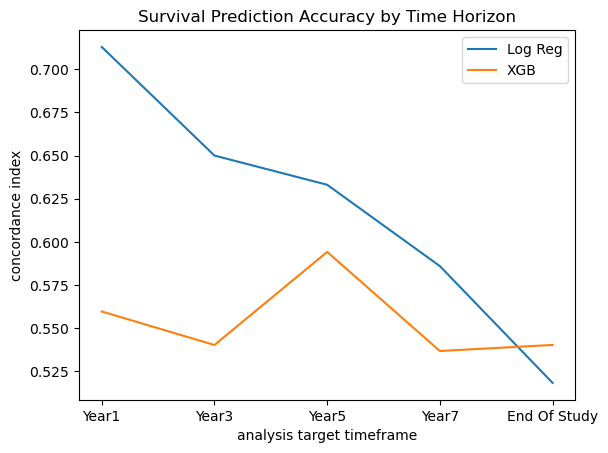

In [89]:
plot_results(models_results, y_timeframes, verbosity=0)

In [90]:
from sksurv.linear_model import CoxnetSurvivalAnalysis

In [91]:
# specialist survival algorithms that take the combination of event and time at target
# ~3 minutes
start_time = time.time() # start the timer

classifiers = [
    # ['CoxNet', CoxnetSurvivalAnalysis(verbose=2), 'auto'],
    # ['Surv SVM', FastKernelSurvivalSVM(random_state=randomState, verbose=1), 'auto'],
    # ['Surv Tree', SurvivalTree(random_state=randomState), 'auto'], 
    ['GBSA', GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=randomState, verbose=Verbosity), 'auto'],
    ['CoxPH', CoxPHSurvivalAnalysis(alpha=0.1, verbose=Verbosity), 'auto'],
]

steps = [
        ('preprocess', preprocessor),
        ('scaler', scaler),
        ('stripNaNCols', RemoveColsWithNan()),
        ('variance', VarianceThreshold(threshold=0.4)),
        # ('dbg1', Debug()),
        # ('select', SelectKBest(score_func=cox_fit_and_score_features, k=20)),
        ('selectK', SelectKBest(score_func=cox_fit_and_score_features, k=25)),
        ('dbg1', Debug()),
        # ('dump', Dump()),
]
pipeline = Pipeline(steps, memory='/kaggle/working/pipecache2', verbose=Verbosity)

for name, classifier, importance_getter in classifiers:
    models_results[name] = {'model': classifier}
    models_results[name]['timeframes'] = {}
    # pipeline = Pipeline(steps)
    pipeline.steps.append(['selectRFECV', RFECV(deepcopy(classifier), step=1, importance_getter=importance_getter, verbose=Verbosity)])
    pipeline.steps.append(['clf', classifier])
    # models_results[name]['pipeline'] = deepcopy(pipeline)
    # print('\npipeline: ---------------------------------------------\n', pipeline)
    
    for timeframe_name, Xtrain, Xtest, ytrain, ytest, y, yBool, yOSTime in y_timeframes:
        models_results[name]['timeframes'][timeframe_name] = {}
        tf = models_results[name]['timeframes'][timeframe_name]
        # Fit the model against training set
        print('\nFit Model: ', classifier, '---------------------------------------------')
        print('\nTarget: ', timeframe_name, '---------------------------------------------')
        # print('\nyBool: ', yBool)
        # print('\nytrain.index: ', ytrain.index)
        ySurv_train = format_target_for_Scikit_Survival(pd.concat([yBool[ytrain.index],yOSTime[ytrain.index]], axis=1))
        pipeline.fit(Xtrain, ySurv_train)
        # tf['train_predicted_survival_fn'] = pipeline.baseline_survival_
    
        # Score the model against train set
        print('\nScore Model on Training Set: ', classifier, '---------------------------------------------')
        tf['train_score'] = pipeline.score(Xtrain, ySurv_train)
        tf['cIndex_train'] = tf['train_score']
        print("model score train: %.3f" % tf['train_score'])
        
        # K Fold Cross validation
        print('\nCross validation score Model on Training Set: ', classifier, '---------------------------------------------')
        skf = StratifiedKFold(n_splits=5)
        tf['crossval_scores'] = cross_val_score(pipeline, Xtrain, ySurv_train, cv=skf, n_jobs=1, verbose=2)
        print("model cross val scores train: ", tf['crossval_scores'])

        # Score the model against test set
        print('\nScore Model on test set: ', classifier, '---------------------------------------------')
        ySurv_test = format_target_for_Scikit_Survival(pd.concat([yBool[ytest.index],yOSTime[ytest.index]], axis=1))
        tf['test_score'] = pipeline.score(Xtest, ySurv_test)
        tf['cIndex_test'] = tf['test_score']
        print("model score test: %.3f" % tf['test_score'])

        # predict on the test set
        yHat_test_survival_function = pipeline.predict_survival_function(Xtest)
        tf['yHat_test_survival_function'] = yHat_test_survival_function
        tf['yHat_test_survival_function_array'] = pipeline.predict_survival_function(Xtest, return_array=True)
        tf['yHat_test_survival_function_mean'] = [np.mean(x) for x in zip(*tf['yHat_test_survival_function_array'])]
        
        tf['pipeline'] = deepcopy(pipeline)
        tf['model'] = deepcopy(classifier)

        # print('\nyHat_test_survival_function: ', yHat_test_survival_function)
    
    pipeline.steps.pop(-1) # remove the model step so the pipeline is ready for the next model to be added
    pipeline.steps.pop(-1)

print('%s seconds' % (time.time() - start_time))


Fit Model:  GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42) ---------------------------------------------

Target:  Year1 ---------------------------------------------

Score Model on Training Set:  GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42) ---------------------------------------------
model score train: 0.866

Cross validation score Model on Training Set:  GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42) ---------------------------------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 3.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min remaining:    0.0s


[CV] END .................................................... total time= 3.5min
[CV] END .................................................... total time= 1.5min
[CV] END .................................................... total time= 3.6min
[CV] END .................................................... total time= 1.4min
model cross val scores train:  [0.35459941 0.63652275        nan        nan        nan]

Score Model on test set:  GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42) ---------------------------------------------
model score test: 0.642


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.6min finished



Fit Model:  GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42) ---------------------------------------------

Target:  Year3 ---------------------------------------------

Score Model on Training Set:  GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42) ---------------------------------------------
model score train: 0.881

Cross validation score Model on Training Set:  GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42) ---------------------------------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 3.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min remaining:    0.0s


[CV] END .................................................... total time= 3.6min
[CV] END .................................................... total time= 3.4min
[CV] END .................................................... total time= 3.6min
[CV] END .................................................... total time= 3.5min
model cross val scores train:  [0.72156863 0.69834001 0.76671408 0.56638116 0.66677155]

Score Model on test set:  GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42) ---------------------------------------------
model score test: 0.721


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 17.6min finished



Fit Model:  GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42) ---------------------------------------------

Target:  Year5 ---------------------------------------------

Score Model on Training Set:  GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42) ---------------------------------------------
model score train: 0.890

Cross validation score Model on Training Set:  GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42) ---------------------------------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 3.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min remaining:    0.0s


[CV] END .................................................... total time= 3.7min
[CV] END .................................................... total time= 3.7min
[CV] END .................................................... total time= 3.8min
[CV] END .................................................... total time= 3.5min
model cross val scores train:  [0.67199559 0.61548975 0.72187322 0.64116177        nan]

Score Model on test set:  GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42) ---------------------------------------------
model score test: 0.683


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 18.3min finished



Fit Model:  GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42) ---------------------------------------------

Target:  Year7 ---------------------------------------------

Score Model on Training Set:  GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42) ---------------------------------------------
model score train: 0.908

Cross validation score Model on Training Set:  GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42) ---------------------------------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 3.9min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.9min remaining:    0.0s


[CV] END .................................................... total time= 4.0min
[CV] END .................................................... total time= 3.7min
[CV] END .................................................... total time= 3.9min
[CV] END .................................................... total time= 4.0min
model cross val scores train:  [       nan 0.61298077 0.689787   0.60521458 0.69180523]

Score Model on test set:  GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42) ---------------------------------------------
model score test: 0.628


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 19.4min finished



Fit Model:  GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42) ---------------------------------------------

Target:  End Of Study ---------------------------------------------

Score Model on Training Set:  GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42) ---------------------------------------------
model score train: 0.862

Cross validation score Model on Training Set:  GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42) ---------------------------------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 3.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min remaining:    0.0s


[CV] END .................................................... total time= 3.7min
[CV] END .................................................... total time= 3.6min
[CV] END .................................................... total time= 3.6min
[CV] END .................................................... total time= 3.8min
model cross val scores train:  [0.3793782  0.50828313 0.4358747  0.4406916  0.44630404]

Score Model on test set:  GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42) ---------------------------------------------
model score test: 0.366


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 18.4min finished



Fit Model:  CoxPHSurvivalAnalysis(alpha=0.1) ---------------------------------------------

Target:  Year1 ---------------------------------------------

Score Model on Training Set:  CoxPHSurvivalAnalysis(alpha=0.1) ---------------------------------------------
model score train: 0.772

Cross validation score Model on Training Set:  CoxPHSurvivalAnalysis(alpha=0.1) ---------------------------------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  20.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.8s remaining:    0.0s


[CV] END .................................................... total time=  21.8s
[CV] END .................................................... total time=   4.6s
[CV] END .................................................... total time=  22.1s
[CV] END .................................................... total time=   4.1s
model cross val scores train:  [0.43026706 0.71995333        nan        nan        nan]

Score Model on test set:  CoxPHSurvivalAnalysis(alpha=0.1) ---------------------------------------------
model score test: 0.483


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished



Fit Model:  CoxPHSurvivalAnalysis(alpha=0.1) ---------------------------------------------

Target:  Year3 ---------------------------------------------

Score Model on Training Set:  CoxPHSurvivalAnalysis(alpha=0.1) ---------------------------------------------
model score train: 0.791

Cross validation score Model on Training Set:  CoxPHSurvivalAnalysis(alpha=0.1) ---------------------------------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  23.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.3s remaining:    0.0s


[CV] END .................................................... total time=  23.9s
[CV] END .................................................... total time=  21.0s
[CV] END .................................................... total time=  22.8s
[CV] END .................................................... total time=  22.3s
model cross val scores train:  [0.70718954 0.71150544 0.75604552 0.67708779 0.6500944 ]

Score Model on test set:  CoxPHSurvivalAnalysis(alpha=0.1) ---------------------------------------------
model score test: 0.734


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished



Fit Model:  CoxPHSurvivalAnalysis(alpha=0.1) ---------------------------------------------

Target:  Year5 ---------------------------------------------

Score Model on Training Set:  CoxPHSurvivalAnalysis(alpha=0.1) ---------------------------------------------
model score train: 0.795

Cross validation score Model on Training Set:  CoxPHSurvivalAnalysis(alpha=0.1) ---------------------------------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  24.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.0s remaining:    0.0s


[CV] END .................................................... total time=  24.2s
[CV] END .................................................... total time=  22.2s
[CV] END .................................................... total time=  25.8s
[CV] END .................................................... total time=  25.8s
model cross val scores train:  [0.71223815 0.70159453 0.77213021 0.60430981        nan]

Score Model on test set:  CoxPHSurvivalAnalysis(alpha=0.1) ---------------------------------------------
model score test: 0.634


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished



Fit Model:  CoxPHSurvivalAnalysis(alpha=0.1) ---------------------------------------------

Target:  Year7 ---------------------------------------------

Score Model on Training Set:  CoxPHSurvivalAnalysis(alpha=0.1) ---------------------------------------------
model score train: 0.786

Cross validation score Model on Training Set:  CoxPHSurvivalAnalysis(alpha=0.1) ---------------------------------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  24.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.3s remaining:    0.0s


[CV] END .................................................... total time=  27.3s
[CV] END .................................................... total time=  27.6s
[CV] END .................................................... total time=  20.9s
[CV] END .................................................... total time=  24.2s
model cross val scores train:  [       nan 0.61586538 0.68705625 0.66635902 0.72446556]

Score Model on test set:  CoxPHSurvivalAnalysis(alpha=0.1) ---------------------------------------------
model score test: 0.684


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min finished



Fit Model:  CoxPHSurvivalAnalysis(alpha=0.1) ---------------------------------------------

Target:  End Of Study ---------------------------------------------

Score Model on Training Set:  CoxPHSurvivalAnalysis(alpha=0.1) ---------------------------------------------
model score train: 0.649

Cross validation score Model on Training Set:  CoxPHSurvivalAnalysis(alpha=0.1) ---------------------------------------------


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  26.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.3s remaining:    0.0s


[CV] END .................................................... total time=  23.0s
[CV] END .................................................... total time=  22.3s
[CV] END .................................................... total time=  26.4s
[CV] END .................................................... total time=  21.5s
model cross val scores train:  [0.46202283 0.47816265 0.43262411 0.4624045  0.38819154]

Score Model on test set:  CoxPHSurvivalAnalysis(alpha=0.1) ---------------------------------------------
model score test: 0.408


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished


7419.328291654587 seconds


In [92]:
with open('models_results.pkl', 'wb') as f:
    pickle.dump(models_results, f)


In [93]:
with open('models_results.pkl', 'rb') as f:
    models_results = pickle.load(f)

{'Log Reg': [0.7129629629629629, 0.6500361532899493, 0.6331189710610933, 0.5860005204267499, 0.5183374083129584], 'XGB': [0.5597222222222222, 0.5403109182935647, 0.5942122186495177, 0.5368201925578975, 0.5403422982885085], 'GBSA': [0.6416666666666667, 0.7207158351409978, 0.6831189710610932, 0.6276346604215457, 0.3663406682966585], 'CoxPH': [0.48333333333333334, 0.7339117859725235, 0.6340836012861736, 0.6841009627894874, 0.4083129584352078]}


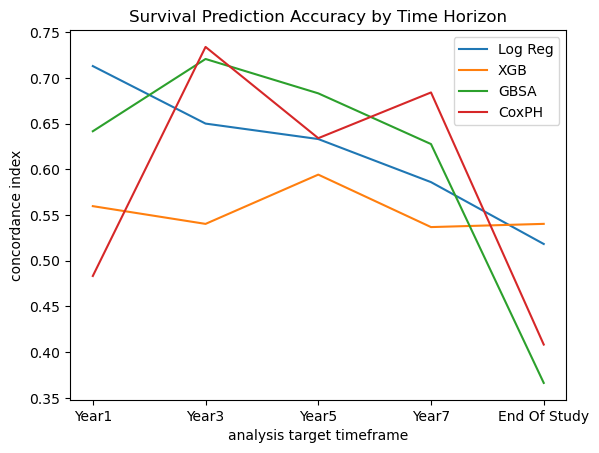

In [94]:
# plot model accuracy evaluation results by time horizon 
plot_results(models_results, y_timeframes, Verbosity)

[0.6500361532899493, 0.5403109182935647, 0.7207158351409978, 0.7339117859725235]


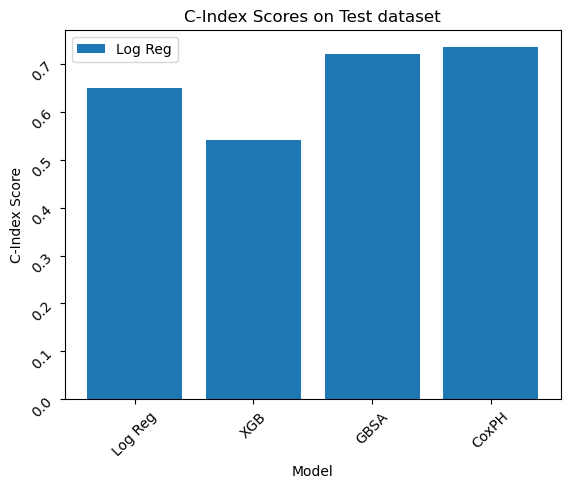

In [95]:
# Create a bar chart of model C index scores
cIndex_test_scores = [models_results[key]['timeframes']['Year3']['cIndex_test'] for key in models_results.keys()]
print(cIndex_test_scores)
plt.bar(models_results.keys(), cIndex_test_scores)
plt.xlabel('Model')
plt.ylabel('C-Index Score')
plt.title('C-Index Scores on Test dataset')
plt.legend(models_results.keys())
plt.tick_params(rotation=45)
plt.show()

In [96]:
model =  models_results['CoxPH']['timeframes']['Year3']['model']
print(model)

CoxPHSurvivalAnalysis(alpha=0.1)


In [97]:
fn = model.baseline_survival_
fn

StepFunction(x=array([0.00000000e+00, 3.28763520e-02, 1.64381760e-01, 2.30134464e-01,
       2.63010816e-01, 2.95887168e-01, 3.28763520e-01, 3.61639872e-01,
       6.24650689e-01, 6.90403393e-01, 7.89032449e-01, 8.54785153e-01,
       9.86290561e-01, 1.01916691e+00, 1.11779597e+00, 1.31505408e+00,
       1.61094125e+00, 1.67669395e+00, 1.70957031e+00, 1.93970477e+00,
       2.10408653e+00, 2.30134464e+00, 2.36709735e+00, 2.49860276e+00,
       2.56435546e+00, 2.59723181e+00, 2.63010816e+00, 2.76161357e+00,
       2.95887168e+00, 3.02462439e+00, 3.22188250e+00, 3.81365684e+00,
       3.87940954e+00, 4.40543117e+00, 4.89857645e+00, 5.19446362e+00,
       5.26021633e+00, 5.32596903e+00, 5.35884538e+00, 5.58897985e+00,
       5.65473255e+00, 5.72048525e+00, 5.85199066e+00, 6.11500148e+00,
       6.14787783e+00, 6.44376500e+00, 6.47664135e+00, 6.57527041e+00,
       6.90403393e+00, 7.00266298e+00, 7.03553934e+00, 7.06841569e+00,
       7.10129204e+00, 7.13416839e+00, 7.16704474e+00, 7.29855

Text(0.5, 1.0, 'Predicted Vs Actual Survival Function by Model, 3 Year Test Set')

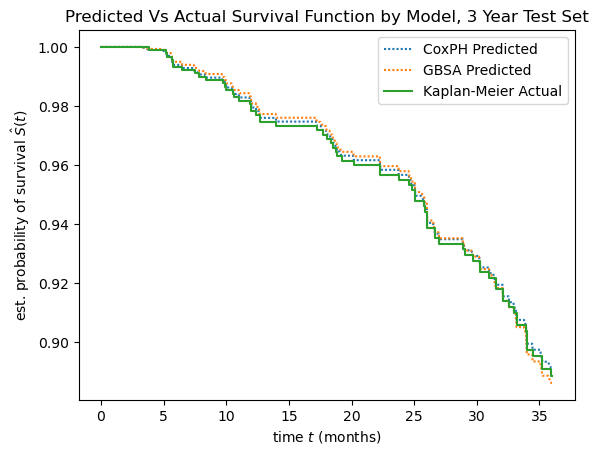

In [98]:
# plot actual KM curve for training set
# Year3
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

# y_data = np.array(y.astype(bool)).flatten()
timeframe_name, Xtrain, Xtest, ytrain, ytest, y, yBool, yOSTime = y_timeframes[1] # Year 3

surv_time, survival_prob, conf_int = kaplan_meier_estimator(
    yBool[ytrain.index], yOSTime[ytrain.index], conf_type="log-log"
    # data_y["Status"], data_y["Survival_in_days"], conf_type="log-log"
)
# plt.step(fn.x, fn(fn.x), where="post", label="CoxPH Prediction") # predicted survival function produced by model during fit
plt.plot(surv_time, models_results['CoxPH']['timeframes']['Year3']['yHat_test_survival_function_mean'], label="CoxPH Predicted", linestyle=(0,(1,1))) # Mean of probabilities for each sample at each timestep
plt.plot(surv_time, models_results['GBSA']['timeframes']['Year3']['yHat_test_survival_function_mean'], label="GBSA Predicted", linestyle=(0,(1,1))) # Mean of probabilities for each sample at each timestep
# plt.plot(surv_time, models_results['Surv Tree']['timeframes']['Year3']['yHat_test_survival_function_mean'], label="Surv Tree Predicted", linestyle=(0,(1,1))) # Mean of probabilities for each sample at each timestep
plt.step(surv_time, survival_prob, where="post",label="Kaplan-Meier Actual") # KM curve based on actuals
# plt.fill_between(surv_time, conf_int[0], conf_int[1], alpha=0.25, step="post") # confidence interval for KM curve based on actuals
# plt.ylim(0.8, 1)
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (months)")
plt.legend()
plt.title("Predicted Vs Actual Survival Function by Model, 3 Year Test Set")

# Calculate Shapley feature explanations for top models

In [99]:
# import shap

def calc_shap(model, pipe, target_timeframe):
    pipe.steps.pop(-1) # remove the model step from the pipeline so we can use it to transform X

    print('Calculate Shap values for model: ', model)
    print('Target timeframe dataset: ', target_timeframe[0])
    # print(pipe)
    # print(pipe.feature_names_in_)

    XtrainXfm = pipe.transform(target_timeframe[1])
    ex = shap.KernelExplainer(model.predict, XtrainXfm)

    XtestXfm = pipe.transform(target_timeframe[2])

    start_time = time.time() # start the timer
    shap_values = ex.shap_values(XtestXfm)
    print('%s seconds' % (time.time() - start_time))
    shap.summary_plot(shap_values, XtestXfm)
    
    return ex, shap_values, XtestXfm


In [100]:
shap_explainers = {}
shap_vals = {}
shap_X_test = {}

In [101]:
# calculate Shapley values for Gradient Boosting model
model =  deepcopy(models_results['GBSA']['timeframes']['Year3']['model'])
pipe = deepcopy(models_results['GBSA']['timeframes']['Year3']['pipeline'])
timeframe = y_timeframes[1] # Year 3
# shap_vals['GBSA'], shap_X_test['GBSA'] = calc_shap(model, pipe, timeframe) # ~48 minutes, ~61 minutes
shap_explainers['GBSA'], shap_vals['GBSA'], shap_X_test['GBSA'] = calc_shap(model, pipe, timeframe) # ~48 minutes, ~61 minutes

with open('shap_explainers.pkl', 'wb') as f:
    pickle.dump(shap_explainers, f)
    
with open('shap_vals.pkl', 'wb') as f:
    pickle.dump(shap_vals, f)

with open('shap_X_test.pkl', 'wb') as f:
    pickle.dump(shap_X_test, f)

Calculate Shap values for model:  GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42)
Target timeframe dataset:  Year3


  0%|          | 0/243 [00:00<?, ?it/s]

113.78934645652771 seconds


Calculate Shap values for model:  CoxPHSurvivalAnalysis(alpha=0.1)
Target timeframe dataset:  Year3


  0%|          | 0/243 [00:00<?, ?it/s]

750.0573172569275 seconds


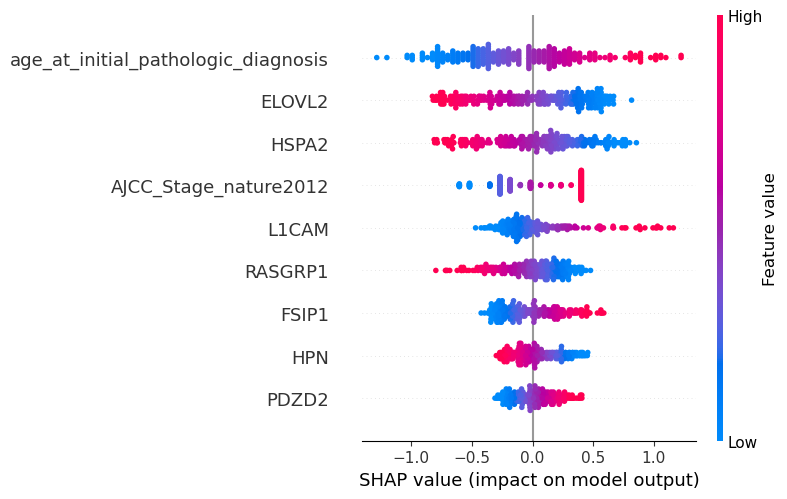

In [102]:
# calculate Shapley values for Cox PH model
model =  deepcopy(models_results['CoxPH']['timeframes']['Year3']['model'])
pipe = deepcopy(models_results['CoxPH']['timeframes']['Year3']['pipeline'])
shap_explainers['CoxPH'], shap_vals['CoxPH'], shap_X_test['CoxPH'] = calc_shap(model, pipe, timeframe) # ~49 minutes

with open('shap_explainers.pkl', 'wb') as f:
    pickle.dump(shap_explainers, f)
    
with open('shap_vals.pkl', 'wb') as f:
    pickle.dump(shap_vals, f)

with open('shap_X_test.pkl', 'wb') as f:
    pickle.dump(shap_X_test, f)

In [103]:
# calculate Shapley values for Logistic Regression model
model =  deepcopy(models_results['Log Reg']['timeframes']['Year3']['model'])
pipe = deepcopy(models_results['Log Reg']['timeframes']['Year3']['pipeline'])
shap_explainers['Log Reg'], shap_vals['Log Reg'], shap_X_test['Log Reg'] = calc_shap(model, pipe, timeframe)

with open('shap_explainers.pkl', 'wb') as f:
    pickle.dump(shap_explainers, f)
    
with open('shap_vals.pkl', 'wb') as f:
    pickle.dump(shap_vals, f)
    
with open('shap_X_test.pkl', 'wb') as f:
    pickle.dump(shap_X_test, f)

Calculate Shap values for model:  LogisticRegression(random_state=42)
Target timeframe dataset:  Year3


  0%|          | 0/243 [00:00<?, ?it/s]

173.80363726615906 seconds


In [104]:
# restore shap data and results
with open('shap_explainers.pkl', 'rb') as f:
    shap_explainers = pickle.load(f)

with open('shap_vals.pkl', 'rb') as f:
    shap_vals = pickle.load(f)
    
with open('shap_X_test.pkl', 'rb') as f:
    shap_X_test = pickle.load(f)

In [105]:
if Verbosity > 0:
    print(shap_vals)
    print(shap_X_test)

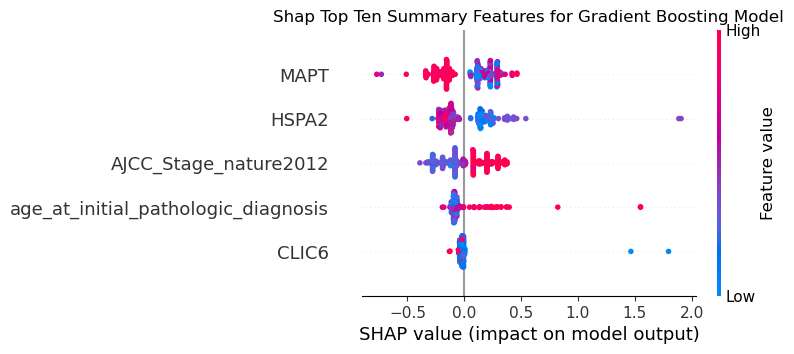

In [106]:
# Shap Top Ten Summary Features for Gradient Boosting Model
shap.summary_plot(shap_vals['GBSA'], shap_X_test['GBSA'], max_display=10, show=False)
plt.title("Shap Top Ten Summary Features for Gradient Boosting Model")
plt.savefig("Shap Top Ten Summary Gradient Boosting.png") #.png,.pdf will also support here
plt.show()

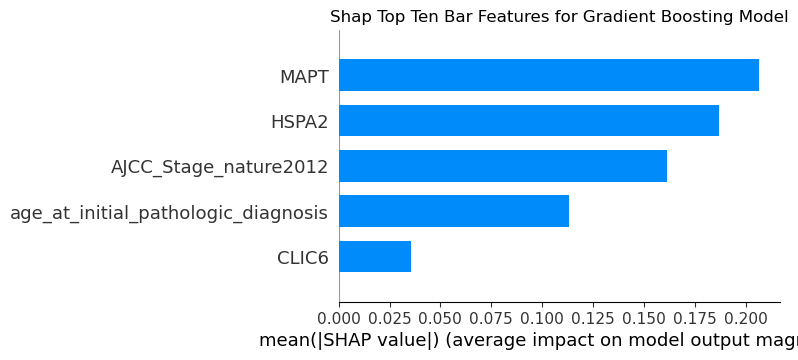

In [107]:
# Top ten features by impact for Gradient Boosting Model
shap.summary_plot(shap_vals['GBSA'], shap_X_test['GBSA'], plot_type='bar', max_display=10, show=False)
plt.title("Shap Top Ten Bar Features for Gradient Boosting Model")
plt.savefig("Shap Top Ten Bar Gradient Boosting.png") #.png,.pdf will also support here
plt.show()

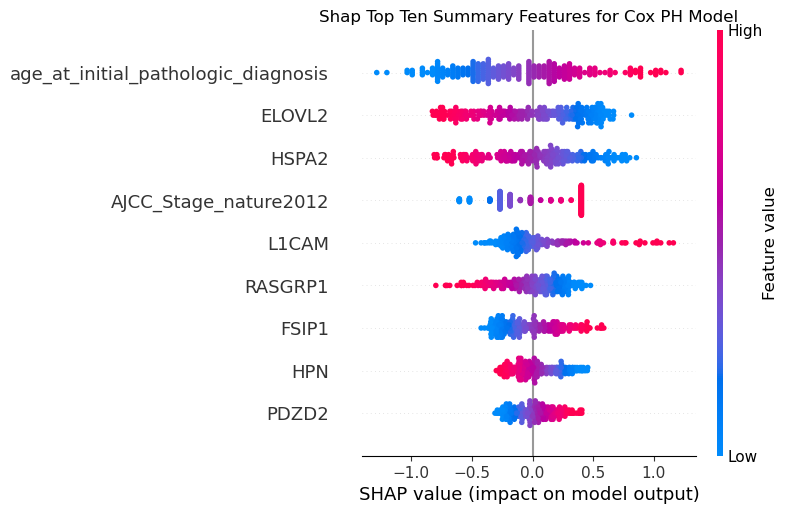

In [108]:
# Shap summary plot for top 10 features, Cox PH model
shap.summary_plot(shap_vals['CoxPH'], shap_X_test['CoxPH'], max_display=10, show=False)
plt.title("Shap Top Ten Summary Features for Cox PH Model")
plt.savefig("Shap Top Ten Summary Cox PH.png") #.png,.pdf will also support here
plt.show()

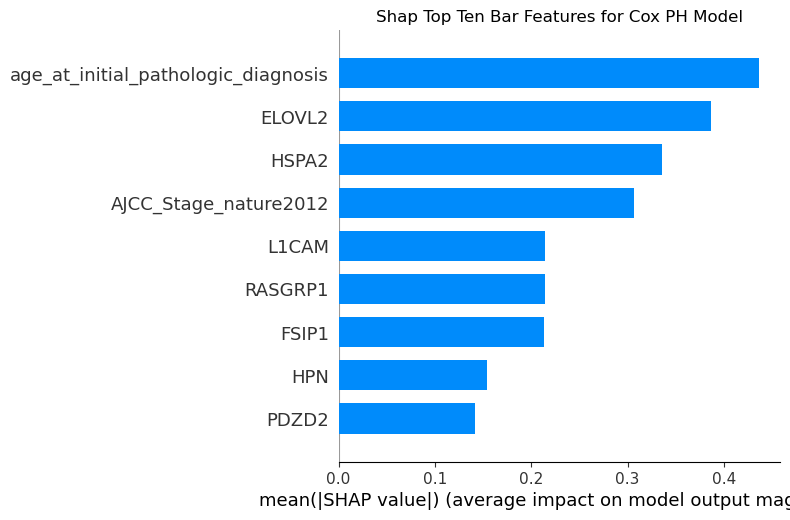

In [109]:
# Top ten features by impact for Cox PH Model
shap.summary_plot(shap_vals['CoxPH'], shap_X_test['CoxPH'], plot_type='bar', max_display=10, show=False)
plt.title("Shap Top Ten Bar Features for Cox PH Model")
plt.savefig("Shap Top Ten Bar Cox PH.png") #.png,.pdf will also support here
plt.show()

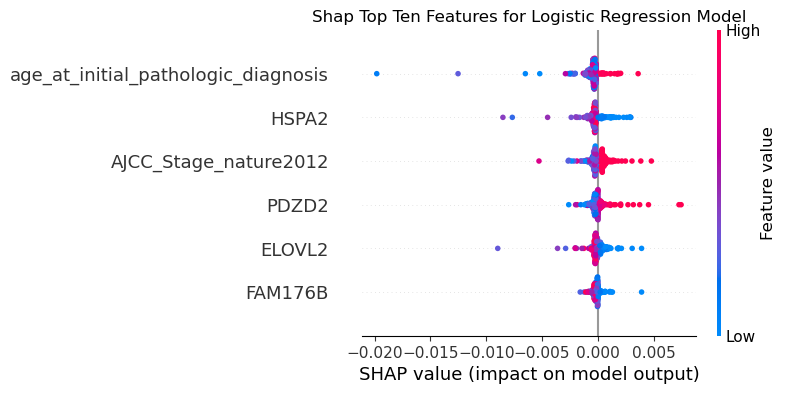

In [110]:
# Shap summary plot for top 10 features, Logistic Regression model
shap.summary_plot(shap_vals['Log Reg'], shap_X_test['Log Reg'], max_display=10, show=False)
plt.title("Shap Top Ten Features for Logistic Regression Model")
plt.savefig("Shap Top Ten Logistic Regression.png") #.png,.pdf will also support here
plt.show()

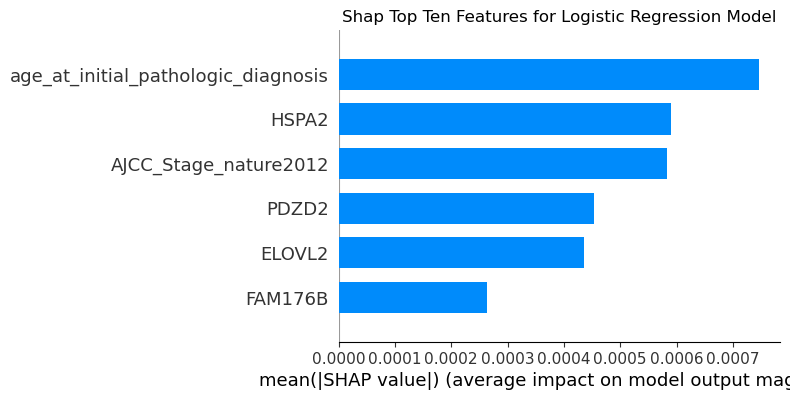

In [111]:
# Top ten features by impact for Logistic Regression Model
shap.summary_plot(shap_vals['Log Reg'], shap_X_test['Log Reg'], max_display=10, plot_type='bar', show=False)
plt.title("Shap Top Ten Features for Logistic Regression Model")
plt.savefig("Shap Top Ten Logistic Regression.png") #.png,.pdf will also support here
plt.show()

In [112]:
models_results['GBSA']['timeframes']['Year3']['model']

GradientBoostingSurvivalAnalysis(dropout_rate=0, random_state=42)

In [113]:
models_results['CoxPH']['timeframes']['Year3']['model'].feature_names_in_

array(['age_at_initial_pathologic_diagnosis', 'FSIP1', 'L1CAM', 'HSPA2',
       'PDZD2', 'RASGRP1', 'HPN', 'ELOVL2', 'AJCC_Stage_nature2012'],
      dtype=object)

In [114]:
models_results['GBSA']['timeframes']['Year3']['model'].feature_names_in_

array(['age_at_initial_pathologic_diagnosis', 'CLIC6', 'MAPT', 'HSPA2',
       'AJCC_Stage_nature2012'], dtype=object)

In [115]:
models_results['Log Reg']['timeframes']['Year3']['model'].feature_names_in_

array(['age_at_initial_pathologic_diagnosis', 'FAM176B', 'HSPA2', 'PDZD2',
       'ELOVL2', 'AJCC_Stage_nature2012'], dtype=object)

In [116]:
np.size(models_results['GBSA']['timeframes']['Year3']['model'].feature_names_in_)

5

243


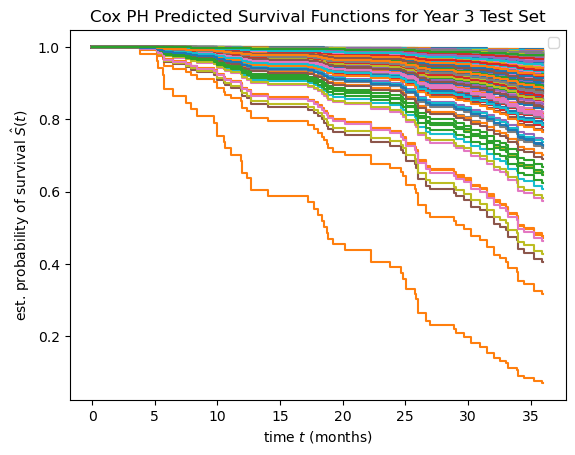

In [117]:
# predicted survival functions from Cox PH model for Year 3 test set
surv_funcs = models_results['CoxPH']['timeframes']['Year3']['yHat_test_survival_function']
print(len(surv_funcs))
for fn in surv_funcs:
     plt.step(fn.x, fn(fn.x), where="post")

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (months)")
plt.legend()
plt.title("Cox PH Predicted Survival Functions for Year 3 Test Set")
# plt.ylim(0, 1)
plt.show()

243


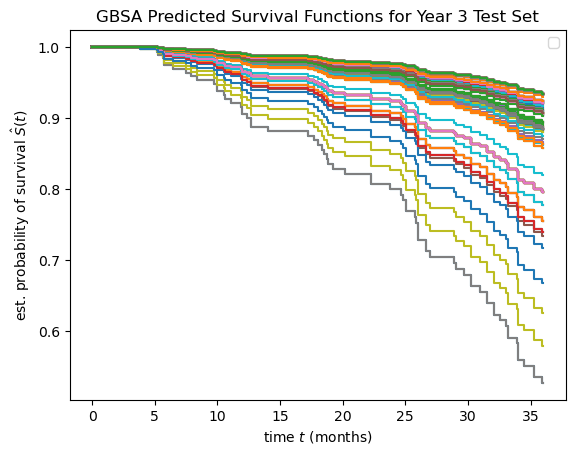

In [118]:
# predicted survival functions from Gradient Boosting model for Year 3 test set
surv_funcs = models_results['GBSA']['timeframes']['Year3']['yHat_test_survival_function']
print(len(surv_funcs))
for fn in surv_funcs:
     plt.step(fn.x, fn(fn.x), where="post")

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (months)")
plt.legend()
plt.title("GBSA Predicted Survival Functions for Year 3 Test Set")
# plt.ylim(0, 1)
plt.show()

# Find highest impact features common to the best models

In [119]:
# find features common to all models...
CoxPH_features = models_results['CoxPH']['timeframes']['Year3']['model'].feature_names_in_
GBSA_features = models_results['GBSA']['timeframes']['Year3']['model'].feature_names_in_
LogReg_features = models_results['Log Reg']['timeframes']['Year3']['model'].feature_names_in_
set(CoxPH_features) & set(GBSA_features) & set(LogReg_features)

{'AJCC_Stage_nature2012', 'HSPA2', 'age_at_initial_pathologic_diagnosis'}

In [120]:
# find features common to multiple models: Cox PH and GBSA...
set(CoxPH_features) & set(GBSA_features)

{'AJCC_Stage_nature2012', 'HSPA2', 'age_at_initial_pathologic_diagnosis'}

In [121]:
# find features common to GBSA and Logistic Regression...
set(GBSA_features) & set(LogReg_features)

{'AJCC_Stage_nature2012', 'HSPA2', 'age_at_initial_pathologic_diagnosis'}

In [122]:
# find features common to Cox PH and Logistic Regression...
set(CoxPH_features) & set(LogReg_features)

{'AJCC_Stage_nature2012',
 'ELOVL2',
 'HSPA2',
 'PDZD2',
 'age_at_initial_pathologic_diagnosis'}

In [123]:
# Top 25 features selected by SelectKBest, using cox_fit_and_score_features() to calculate feature importances
models_results['CoxPH']['timeframes']['Year3']['pipeline'].steps[-2][1].feature_names_in_

array(['age_at_initial_pathologic_diagnosis', 'ASS1', 'ABAT', 'FSIP1',
       'ZNF552', 'CLIC6', 'L1CAM', 'TMEM26', 'AFF3', 'SUSD3', 'LYNX1',
       'SCUBE2', 'MAPT', 'HSPA2', 'NKAIN1', 'PDZD2', 'F2RL2', 'WNK4',
       'RASGRP1', 'HPN', 'DNAJC12', 'ELOVL2', 'GREB1', 'FGD3',
       'AJCC_Stage_nature2012'], dtype=object)

In [124]:
# Top 25 features selected by SelectKBest for Logistic Regression model
models_results['Log Reg']['timeframes']['Year3']['pipeline'].steps[-2][1].feature_names_in_

array(['age_at_initial_pathologic_diagnosis', 'GALNTL2', 'PCK1', 'GABRE',
       'FIGF', 'L1CAM', 'FAM176B', 'SRPX', 'SUSD3', 'HSPA2', 'LYVE1',
       'HBA1', 'NKAIN1', 'PPP1R1A', 'PDZD2', 'CALB2', 'HPN', 'GYG2',
       'ELOVL2', 'FGD3', 'ARNT2', 'TIMP4', 'CST1',
       'AJCC_Stage_nature2012', 'Metastasis_nature2012_M1'], dtype=object)

In [125]:
# Top 25 features selected by SelectKBest for XG Boost model
models_results['XGB']['timeframes']['Year3']['pipeline'].steps[-2][1].feature_names_in_

array(['age_at_initial_pathologic_diagnosis', 'GALNTL2', 'PCK1', 'GABRE',
       'FIGF', 'L1CAM', 'FAM176B', 'SRPX', 'SUSD3', 'HSPA2', 'LYVE1',
       'HBA1', 'NKAIN1', 'PPP1R1A', 'PDZD2', 'CALB2', 'HPN', 'GYG2',
       'ELOVL2', 'FGD3', 'ARNT2', 'TIMP4', 'CST1',
       'AJCC_Stage_nature2012', 'Metastasis_nature2012_M1'], dtype=object)

In [126]:
set(models_results['CoxPH']['timeframes']['Year3']['pipeline'].steps[-2][1].feature_names_in_) & set(models_results['Log Reg']['timeframes']['Year3']['pipeline'].steps[-2][1].feature_names_in_)

{'AJCC_Stage_nature2012',
 'ELOVL2',
 'FGD3',
 'HPN',
 'HSPA2',
 'L1CAM',
 'NKAIN1',
 'PDZD2',
 'SUSD3',
 'age_at_initial_pathologic_diagnosis'}

In [127]:
yHat_test_prob = []
yHat_test_pred = []

for fn in surv_funcs:
    # plt.step(fn.x, fn(fn.x), where="post")
    last_prob = fn(fn.x[-1])
    yHat_test_prob.append(last_prob)
    yHat_test_pred.append(round(last_prob))
    
print(yHat_test_prob)
print(yHat_test_pred)

[0.52719422134072, 0.7957966012352965, 0.882853090568544, 0.8848197063273865, 0.9073825959400329, 0.7957966012352965, 0.9073825959400329, 0.9110429644349788, 0.9343819684686933, 0.8948518155830532, 0.9343819684686933, 0.9057211511487868, 0.9073825959400329, 0.9238912465693118, 0.9343819684686933, 0.7549777671402149, 0.7549777671402149, 0.9209411813653157, 0.7549777671402149, 0.8614616684198796, 0.9092944472601494, 0.9343819684686933, 0.9343819684686933, 0.9073825959400329, 0.9343819684686933, 0.7957966012352965, 0.8849465514752737, 0.8849465514752737, 0.9343819684686933, 0.9343819684686933, 0.9343819684686933, 0.8807347303107688, 0.8849465514752737, 0.8948518155830532, 0.9343819684686933, 0.7957966012352965, 0.9073825959400329, 0.9343819684686933, 0.9343819684686933, 0.7957966012352965, 0.8878125202895697, 0.9073825959400329, 0.9343819684686933, 0.9073825959400329, 0.8849465514752737, 0.9238912465693118, 0.9343819684686933, 0.7549777671402149, 0.7957966012352965, 0.8807347303107688, 0.

In [128]:
len(yHat_test_pred)

243

In [129]:
cox_f1 = f1_score(y_test.OS, yHat_test_pred)
print("F1 score: ", cox_f1)

F1 score:  0.2826855123674912


In [130]:
cI_test = concordance_index_censored(y_test.OSBool, y_test['OS.time'], yHat_test_prob)
cI_test


(0.4748809523809524, 1789, 2000, 411, 3)

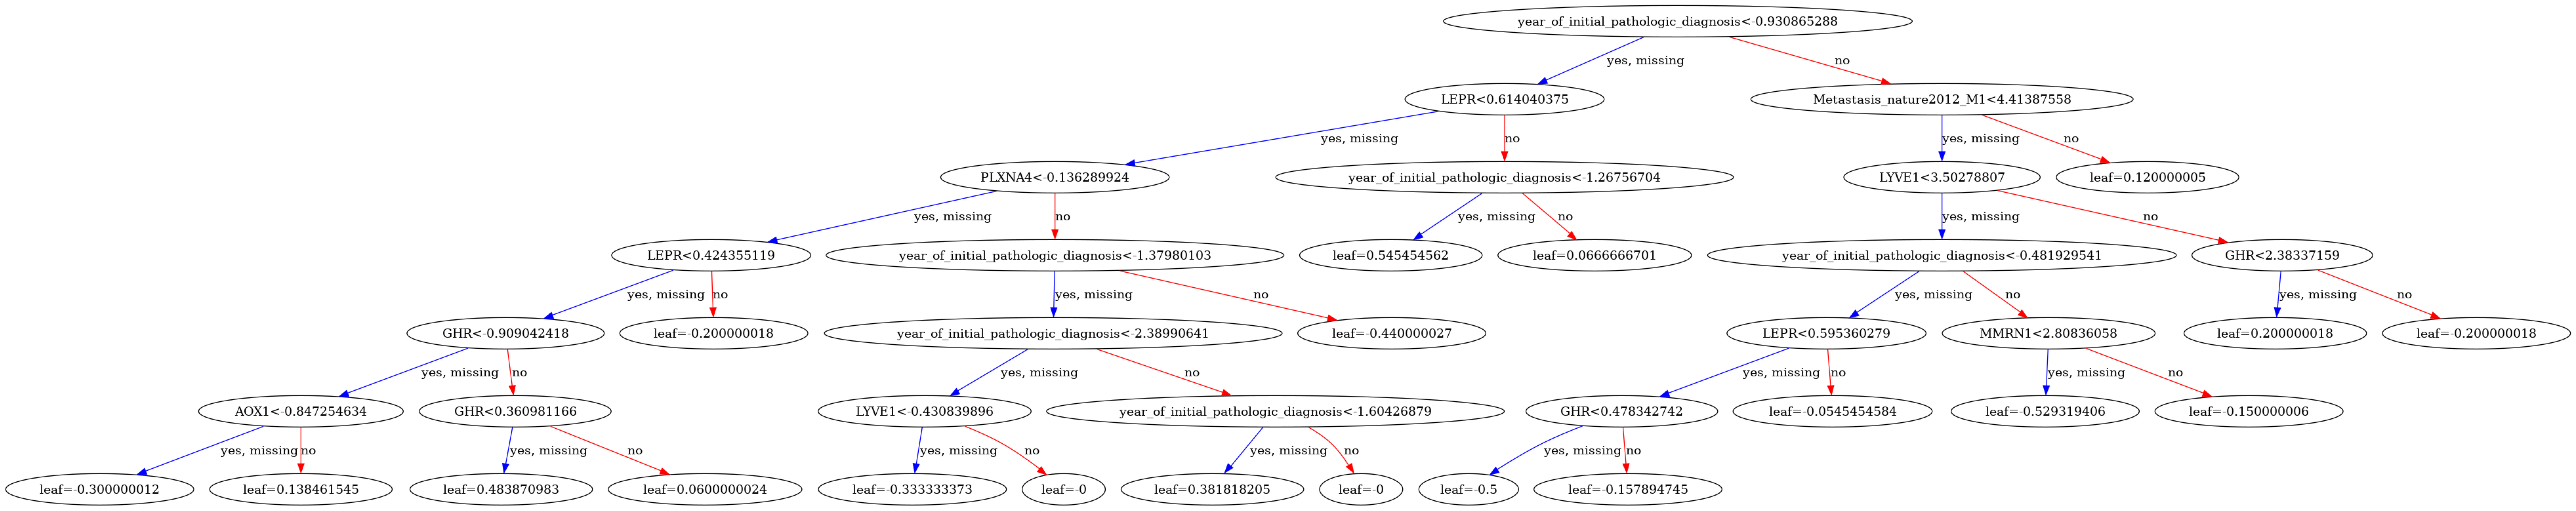

In [131]:
# Plot decision tree for XGB model
from xgboost import plot_tree
XGBmodel = models_results['XGB']['model']
plot_tree(XGBmodel)

fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')


In [132]:
# calculate feature importances for XGB model
featureImportanceDict = XGBmodel.get_booster().get_score(importance_type='gain')
df = pd.DataFrame.from_dict(featureImportanceDict, orient='index', columns=['value'])
df = df.sort_values(by=['value'], ascending=False)
df

value
year_of_initial_pathologic_diagnosis  4.915650
Metastasis_nature2012_M1              3.675917
LYVE1                                 1.043506
MMRN1                                 0.905339
IGSF10                                0.837117
PLXNA4                                0.833069
GHR                                   0.832293
PDZD2                                 0.789480
LEPR                                  0.726782
ALDH1L1                               0.674276
FAM107A                               0.651732
AOX1                                  0.647745
TIMP4                                 0.612002

## Appendix